# Loading Packages

In [1]:
# !pip3 install torch==1.9.1+cu102 torchvision==0.10.1+cu102 torchaudio===0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install imblearn
# !pip install graphviz
# !pip install torchviz
# !pip install torchsummary

In [1]:
# Basic Python Packages
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# Torch Packages
import torch
import torchvision
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torchviz import make_dot
from torchsummary import summary

# ML Test and Validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Other
import cv2
from tqdm import tqdm
from copy import deepcopy
from random import *
import graphviz

# Our functions
from processing_functions_2 import *

# Formatting
pd.set_option('max_colwidth', 1000)

# Making the Data

## Make the Segmented Teeth

In [3]:
# # Run this cell once

# # Global vars for loading data
# output_path = 'C:/Documents/Dental_Detection/Segmented_Images_7/'

# # Path
# xray_path = 'D:/dental_training_images/images/'
# anomaly_path = 'D:/dental_training_images/labels/'
# segmentation_path = 'D:/dental_training_images/segments/'

# # Make the data
# make_data(xray_path=xray_path, anomaly_path=anomaly_path, segmentation_path=segmentation_path, output_path=output_path)

## Make the Clahe Images

In [4]:
# # Make clahe train
# # Do once

# # paths and train df
# output_path = 'C:/Documents/Dental_Detection/Segmented_Images_7_clahe/'
# train_df = pd.read_csv('C:/Documents/Dental_Detection/data_csv/train_data_pano0_6.csv')

# # make the clahe images
# make_clahe(train_df=train_df, output_path=output_path)

In [5]:
# # Make clahe valid
# # Do once

# # paths and valid df
# output_path = 'C:/Documents/Dental_Detection/Segmented_Images_7_clahe/'
# valid_df = pd.read_csv('C:/Documents/Dental_Detection/data_csv/valid_data_pano0_6.csv')

# # make the clahe images
# make_clahe(df=valid_df, output_path=output_path)

## Make the Augmented Images

In [6]:
# # Make augmentations
# # Do once
# which_anomaly = [1, 2, 3, 4, 5, 6, 8]
# train_path = 'C:/Documents/Dental_Detection/Segmented_Images_7_aug/'
# make_augments('C:/Documents/Dental_Detection/data_csv/train_clahe_data_pano0_6.csv', train_path=train_path, which_anomaly=which_anomaly,
#               add_rotation=True, add_flip=True, add_noise=True, add_blur=True)

In [7]:
# # Make clahe augmentations
# # Do once
# which_anomaly = [1, 2, 3, 4, 5, 6, 8]
# train_path = 'C:/Documents/Dental_Detection/Segmented_Images_7_aug_clahe/'
# make_augments('C:/Documents/Dental_Detection/data_csv/train_clahe_data_pano0_6.csv', train_path=train_path, which_anomaly=which_anomaly,
#               add_rotation=True, add_flip=True, add_noise=True, add_blur=True)

# EDA

In [2]:
train_df = pd.read_csv('C:/Documents/Dental_Detection/data_csv/train_data_pano0_6.csv')
valid_df = pd.read_csv('C:/Documents/Dental_Detection/data_csv/valid_clahe_data_pano0_6.csv')
train_aug_df = pd.read_csv('C:/Documents/Dental_Detection/data_csv/train_aug_data_pano0_6.csv')
train_aug_df = filter_rotation(train_aug_df, [[0, 10], [170, 190], [350, 360]])

In [3]:
train_df.groupby('anomaly_codes').count()

,Unnamed: 0,file_path
anomaly_codes,,
0.0,1377,1377
1.0,205,205
2.0,30,30
3.0,14,14
4.0,53,53
5.0,61,61
6.0,108,108
7.0,9033,9033
8.0,155,155


Text(0, 0.5, 'count')

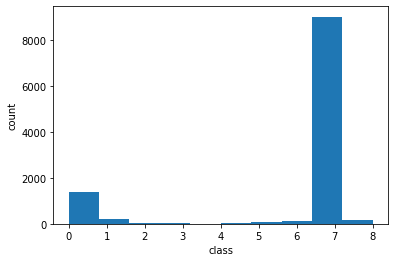

In [10]:
plt.hist(train_df['anomaly_codes'])
plt.xlabel('class')
plt.ylabel('count')

In [11]:
valid_df.groupby('anomaly_codes').count()

,Unnamed: 0,file_path
anomaly_codes,,
0.0,344,344
1.0,51,51
2.0,8,8
3.0,3,3
4.0,14,14
5.0,15,15
6.0,27,27
7.0,2258,2258
8.0,39,39


Text(0, 0.5, 'count')

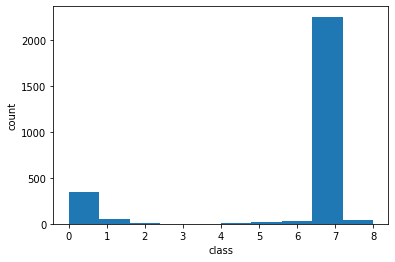

In [12]:
plt.hist(valid_df['anomaly_codes'])
plt.xlabel('class')
plt.ylabel('count')

In [13]:
train_aug_df.groupby('anomaly_codes').count()

,Unnamed: 0,file_path,is_rotated,is_flipped,is_noise,is_blur,in_rotation_angle
anomaly_codes,,,,,,,
0.0,1377,1377,1377,1377,1377,1377,1377
1.0,2870,2870,2870,2870,2870,2870,2870
2.0,420,420,420,420,420,420,420
3.0,196,196,196,196,196,196,196
4.0,742,742,742,742,742,742,742
5.0,854,854,854,854,854,854,854
6.0,1512,1512,1512,1512,1512,1512,1512
7.0,9033,9033,9033,9033,9033,9033,9033
8.0,2170,2170,2170,2170,2170,2170,2170


Text(0, 0.5, 'count')

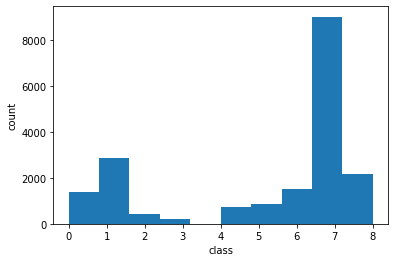

In [14]:
plt.hist(train_aug_df['anomaly_codes'])
plt.xlabel('class')
plt.ylabel('count')

# Class Definitions

## _TeethDataLoader_

In [2]:
class TeethDataLoader(data.Dataset):
    
    def __init__(self, path_to_df, anomalies_to_include, check_augments, augments_to_include):
        """
        path_to_df: the path to the main data frame ex. ~/Documents/Dental/segmented_data.csv
        anomalies_to_include: list of anomlies based on code ex. [0, 1, 2, 3, 4, 5, 6, 7, 8]
        augments_to_include: list of augment bools to include as list of 1s and Os 
                             ex. [1, 1, 1, 1] == [rotation, flip, noise, blur]
                             ex. [1, 1, 0, 0] == [rotation, flip, no noise, no blur]
        """
        # Read in data
        df = pd.read_csv(path_to_df)
        
        # Filter out which anomalies
        df = df[df['anomaly_codes'].isin(anomalies_to_include)]
        
        if check_augments:
            # Filter out which augmentations to include
            include_rotations = augments_to_include[0]
            include_flips = augments_to_include[1]
            include_noise = augments_to_include[2]
            include_blur = augments_to_include[3]

            if(include_rotations == 0):
                df = df[df['is_rotated'] == 0]
            else:
                df = filter_rotation(df, [[0, 10], [170, 190], [350, 360]])
            if(include_flips == 0):
                df = df[df['is_flipped'] == 0]
            if(include_noise == 0):
                df = df[df['is_noise'] == 0]
            if(include_blur == 0):
                df = df[df['is_blur'] == 0]

        self.images, self.labels = df['file_path'].tolist(), df['anomaly_codes'].tolist()
        
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = cv2.imread(self.images[index])     # loads image from file
        img = cv2.resize(img, (224, 224))        # resize image to 224x224
        
        # clahe
#         clahe = cv2.createCLAHE(clipLimit=12.0, tileGridSize=(8,8))
#         img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         img2 = clahe.apply(img1)
#         img = cv2.hconcat([img1,img2])
        
        # more processing
        img = np.array(img, dtype=np.float32)    # change data type to float
        img = (img / 255.)                       # normalize colors to be 0-1
        img = img[:, :, (2, 1, 0)]               # reorder RGB
        img = torchvision.transforms.ToTensor()(img)  # convert to tensor
        label = self.labels[index]               # Make label
        
        return img.float(), torch.FloatTensor([label]) # returns tensor of modified image and label

## Defining the Model Classes and Layers

In [3]:
class BasicConv(nn.Module):
    # initialize class
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, 
                 padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        # def conv layer, in_planes/out_planes = size of features
        self.conv = nn.Conv2d(in_planes, out_planes, 
                              kernel_size=kernel_size, stride=stride, 
                              padding=padding, dilation=dilation,
                              groups=groups, bias=bias)
        # batch normalization - normalization of the layers' inputs by re-centering and re-scaling
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        # ReLu activation
        self.relu = nn.ReLU() if relu else None

    # create feed-forward network for conv layer
    def forward(self, x):
        x = self.conv(x)           # only 1 layer
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x
 
    
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1) # reshape to flatten tensor which is necessary in order to pass data into a linear layer
                                     # add -1
                                     # no flatten function in pytorch so need to create it

            
class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
        
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

    
def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

       
class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

       
class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
            
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

In [4]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes * 4, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers,  network_type, num_classes, att_type=None):
        self.inplanes = 64
        super(ResNet, self).__init__()

        self.network_type = network_type
        # different model config between ImageNet and CIFAR 
        if network_type == "ImageNet":
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            self.avgpool = nn.AvgPool2d(7)
        else:
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        if att_type=='BAM':
            self.bam1 = BAM(64*block.expansion)
            self.bam2 = BAM(128*block.expansion)
            self.bam3 = BAM(256*block.expansion)
        else:
            self.bam1, self.bam2, self.bam3 = None, None, None

        self.layer1 = self._make_layer(block, 64,  layers[0], att_type=att_type)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, att_type=att_type)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, att_type=att_type)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, att_type=att_type)

        self.fc = nn.Linear(512 * block.expansion, num_classes)
        #self.fc = nn.Linear(512 * block.expansion, 1) # linear is output of probability distributions
        self.softmax = torch.nn.Sigmoid()
        init.kaiming_normal(self.fc.weight)
        for key in self.state_dict():
            if key.split('.')[-1]=="weight":
                if "conv" in key:
                    init.kaiming_normal(self.state_dict()[key], mode='fan_out')
                if "bn" in key:
                    if "SpatialGate" in key:
                        self.state_dict()[key][...] = 0
                    else:
                        self.state_dict()[key][...] = 1
            elif key.split(".")[-1]=='bias':
                self.state_dict()[key][...] = 0

    def _make_layer(self, block, planes, blocks, stride=1, att_type=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_cbam=att_type=='CBAM'))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_cbam=att_type=='CBAM'))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if self.network_type == "ImageNet":
            x = self.maxpool(x)

        x = self.layer1(x)
        if not self.bam1 is None:
            x = self.bam1(x)

        x = self.layer2(x)
        if not self.bam2 is None:
            x = self.bam2(x)

        x = self.layer3(x)
        if not self.bam3 is None:
            x = self.bam3(x)

        x = self.layer4(x)

        if self.network_type == "ImageNet":
            x = self.avgpool(x)
        else:
            x = F.avg_pool2d(x, 4)
            
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        #return F.normalize(x, dim=-1)
        return self.softmax(x)
    
def ResidualNet(network_type, depth, num_classes, att_type):

    assert network_type in ["ImageNet", "CIFAR10", "CIFAR100"], "network type should be ImageNet or CIFAR10 / CIFAR100"
    assert depth in [5, 18, 34, 50, 101], 'network depth should be 18, 34, 50 or 101'

    if depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], network_type, num_classes, att_type)
        
    elif depth == 5:
        model = ResNet(BasicBlock, [1, 1, 2, 1], network_type, num_classes, att_type)

    elif depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], network_type, num_classes, att_type)

    elif depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], network_type, num_classes, att_type)

    elif depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], network_type, num_classes, att_type)

    return model

## Define Train and Valid Functions

In [5]:
best_accuracy = 0

def train(train_loader, model, classes, optimizer, epoch):
    model.train()
    running_mse = 0
    batch_idx = 0
    correct, total = 0, 0
    confusion_matrix = torch.zeros(classes, classes)
 
    pd, gt = [], []
    for (x, y) in tqdm(train_loader):
        batch_idx += 1
        x = x.to(device) # move data to GPU
        y = y.to(device) # move data to GPU

        out = model(x)
        criterion = nn.CrossEntropyLoss()
        #criterion = nn.BCELoss()                    # binary cross entropy loss
        loss = criterion(out, y.squeeze(1).long())
        #loss = criterion(out.squeeze(1), y.squeeze(1)) # calculate loss based on pred output vs actuals y, 
                                                       # .squeeze removes dimensions of 1
        running_mse += loss.item() 
        optimizer.zero_grad()        # start gradient at 0
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(out.data, 1)
        #predicted = (out.data > 0.5).int()

        for p in predicted:
            pd.append(p)
        for g in y.squeeze(1):
            gt.append(g)

        total += y.squeeze(1).size(0)
        correct += (predicted == y.squeeze(1)).sum().item()
        for t, p in zip(y.squeeze(1).view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
    
    pd = torch.as_tensor(pd).numpy()
    gt = torch.as_tensor(gt).numpy()

    running_mse = running_mse / batch_idx
    print('Epoch %d, loss = %.4f, batch_idx= %d' % (epoch, running_mse, batch_idx))
    print('Epoch: %d Accuracy of the Train Images: %f' %(epoch, 100 * correct / total))
    print('Confusion Matrix\n', np.round(confusion_matrix.cpu().numpy(), 2))
    print('Classification Report\n', classification_report(gt, pd))
    return running_mse, 100*correct/total
    

def valid(valid_loader, model, classes, epoch):
    global best_accuracy
    model.eval()
    correct, total = 0, 0
    running_mse = 0
    batch_idx = 0
    confusion_matrix = torch.zeros(classes, classes)
    pd, gt = [], []
    with torch.no_grad():
        for x, y in tqdm(valid_loader):
            batch_idx += 1
            x = x.to(device)
            y = y.to(device)

            out = model(x) # add .to(device) ???
            criterion = nn.CrossEntropyLoss()
            #criterion = nn.BCELoss()
            loss = criterion(out, y.squeeze(1).long())
            #loss = criterion(out.squeeze(1), y.squeeze(1))
            running_mse += loss.item()
            _, predicted = torch.max(out.data, 1)
            #predicted = (out.data > 0.5).int()

            for p in predicted:
                pd.append(p)
            for g in y.squeeze(1):
                gt.append(g)

            total += y.squeeze(1).size(0)
            correct += (predicted == y.squeeze(1)).sum().item()
            for t, p in zip(y.squeeze(1).view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    if best_accuracy < 100 * (correct/total):
        best_accuracy = 100 * (correct/total)
        
    pd = torch.as_tensor(pd).numpy()
    gt = torch.as_tensor(gt).numpy()
    
    running_mse = running_mse / batch_idx
    print('Epoch: %d Accuracy of the Valid Images: %f' %(epoch, 100 * correct / total))
    print('Confusion Matrix\n', np.round(confusion_matrix.cpu().numpy(), 2))
    print('Classification Report\n', classification_report(gt, pd))
    return running_mse, 100*correct/total

# GPU

In [6]:
# check if GPU available and assign it
torch.cuda.is_available()
device = torch.device('cuda', 1)
# device = torch.device('cpu') # this switches to CPU for debugging
device

device(type='cuda', index=1)

# Making and Running the Models

In [18]:
# Global Variables for the Models
train_path_to_df = 'C:/Documents/Dental_Detection/data_csv/train_aug_data_pano0_6.csv'
valid_path_to_df = 'C:/Documents/Dental_Detection/data_csv/valid_data_pano0_6.csv'
train_clahe_path_to_df = 'C:/Documents/Dental_Detection/data_csv/train_clahe_aug_data_pano0_6.csv'
valid_clahe_path_to_df = 'C:/Documents/Dental_Detection/data_csv/valid_clahe_data_pano0_6.csv'
batch_size = 64
epochs = 30

## _Model 1_

In [21]:
anomalies_to_include_1 = [0, 1, 2, 3, 4, 5, 6, 7]
augments_to_include_1 = [0, 0, 0, 0]

num_classes_1 = len(anomalies_to_include_1)

model_1 = ResidualNet('ImageNet', 5, num_classes_1, 'CBAM')
model_1.to(device) # sends model to GPU
optimizer = optim.Adam(model_1.parameters(), lr=0.00003)

train_dataset_1 = TeethDataLoader(train_path_to_df, anomalies_to_include_1, False, augments_to_include_1)
valid_dataset_1 = TeethDataLoader(valid_path_to_df, anomalies_to_include_1, False, augments_to_include_1)

# generate shuffled sequence of numbers based on how many images, split train/test
train_idx_1 = np.array(range(len(train_dataset_1.labels)))
shuffle(train_idx_1)
valid_idx_1 = np.array(range(len(valid_dataset_1.labels)))
shuffle(valid_idx_1)

# Samples elements randomly from a given list of indices, without replacement
train_sampler_1 = torch.utils.data.SubsetRandomSampler(train_idx_1)
valid_sampler_1 = torch.utils.data.SubsetRandomSampler(valid_idx_1)

# loads images associated with ids/samples from above
train_loader_1 = torch.utils.data.DataLoader(train_dataset_1, batch_size=batch_size, sampler=train_sampler_1)
valid_loader_1 = torch.utils.data.DataLoader(valid_dataset_1, batch_size=batch_size, sampler=valid_sampler_1)

C:\Users\dental-1\AppData\Local\Temp/ipykernel_20244/1289602504.py:123: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.fc.weight)
C:\Users\dental-1\AppData\Local\Temp/ipykernel_20244/1289602504.py:127: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


In [22]:
train_loss_1 = []
valid_loss_1 = []
train_acc_1 = []
valid_acc_1 = []

for epoch in range(1, epochs+1):
    train_epoch_loss, train_epoch_accuracy = train(train_loader_1, model_1, num_classes_1, optimizer, epoch)
    valid_epoch_loss, val_epoch_accuracy = valid(valid_loader_1, model_1, num_classes_1, epoch)
    
    train_loss_1.append(train_epoch_loss)
    valid_loss_1.append(valid_epoch_loss)
    
    train_acc_1.append(train_epoch_accuracy)
    valid_acc_1.append(val_epoch_accuracy)

  0%|          | 0/168 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 168/168 [00:32<00:00,  5.11it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 1, loss = 1.5308, batch_idx= 168
Epoch: 1 Accuracy of the Train Images: 83.957518
Confusion Matrix
 [[1.020e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.212e+03]
 [3.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.480e+02]
 [5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.100e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  4.400e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.300e+01]
 [9.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.400e+01
  8.910e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.42      0.08      0.13      1316
         1.0       0.00      0.00      0.00       184
         2.0       0.00    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  8.68it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 1 Accuracy of the Valid Images: 84.117647
Confusion Matrix
 [[8.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.630e+02]
 [2.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.200e+01]
 [7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.400e+01]
 [5.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.207e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.47      0.24      0.31       344
         1.0       0.00      0.00      0.00        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/168 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 168/168 [00:29<00:00,  5.65it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 2, loss = 1.4088, batch_idx= 168
Epoch: 2 Accuracy of the Train Images: 86.566052
Confusion Matrix
 [[5.850e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.310e+02]
 [1.080e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.600e+01]
 [9.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.600e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.100e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.500e+01]
 [4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.000e+01]
 [3.250e+02 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.707e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.57      0.44      0.50      1316
         1.0       0.00      0.00      0.00       184
         2.0       0.00    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.01it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 2 Accuracy of the Valid Images: 86.102941
Confusion Matrix
 [[1.900e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.540e+02]
 [2.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.200e+01]
 [7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.400e+01]
 [1.060e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.152e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.57      0.55      0.56       344
         1.0       0.00      0.00      0.00        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/168 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 168/168 [00:29<00:00,  5.72it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 3, loss = 1.3826, batch_idx= 168
Epoch: 3 Accuracy of the Train Images: 87.460406
Confusion Matrix
 [[7.470e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.690e+02]
 [1.100e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.400e+01]
 [8.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.700e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.200e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.900e+01]
 [3.850e+02 7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.641e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.59      0.57      0.58      1316
         1.0       0.00      0.00      0.00       184
         2.0       0.00    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.32it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 3 Accuracy of the Valid Images: 86.102941
Confusion Matrix
 [[2.350e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.090e+02]
 [2.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.400e+01]
 [3.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.400e+01]
 [1.430e+02 8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.107e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.57      0.68      0.62       344
         1.0       0.00      0.00      0.00        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/168 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 168/168 [00:29<00:00,  5.73it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 4, loss = 1.3706, batch_idx= 168
Epoch: 4 Accuracy of the Train Images: 88.000745
Confusion Matrix
 [[8.370e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.790e+02]
 [5.500e+01 1.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.180e+02]
 [1.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.200e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.100e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.800e+01]
 [4.160e+02 1.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.598e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.63      0.64      0.64      1316
         1.0       0.33      0.06      0.10       184
         2.0       0.00    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.36it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 4 Accuracy of the Valid Images: 80.147059
Confusion Matrix
 [[2.920e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.200e+01]
 [2.000e+01 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [1.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.100e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [4.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.200e+01]
 [3.660e+02 8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.884e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.42      0.85      0.57       344
         1.0       0.24      0.08      0.12        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/168 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 168/168 [00:29<00:00,  5.74it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 5, loss = 1.3624, batch_idx= 168
Epoch: 5 Accuracy of the Train Images: 89.053475
Confusion Matrix
 [[8.610e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.550e+02]
 [1.800e+01 1.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.520e+02]
 [1.000e+00 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.200e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.100e+01]
 [3.360e+02 1.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.684e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.70      0.65      0.68      1316
         1.0       0.44      0.08      0.13       184
         2.0       0.00    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.25it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 5 Accuracy of the Valid Images: 87.941176
Confusion Matrix
 [[2.010e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.430e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.100e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [6.500e+01 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.191e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.75      0.58      0.66       344
         1.0       0.00      0.00      0.00        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/168 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 168/168 [00:29<00:00,  5.71it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 6, loss = 1.3562, batch_idx= 168
Epoch: 6 Accuracy of the Train Images: 89.388858
Confusion Matrix
 [[8.910e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.250e+02]
 [1.000e+01 1.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.590e+02]
 [1.000e+00 7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.800e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.200e+01]
 [3.310e+02 1.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.689e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.72      0.68      0.70      1316
         1.0       0.43      0.08      0.14       184
         2.0       0.00    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.17it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 6 Accuracy of the Valid Images: 87.794118
Confusion Matrix
 [[1.900e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.540e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.100e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [5.700e+01 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.198e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.77      0.55      0.64       344
         1.0       0.00      0.00      0.00        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/168 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 168/168 [00:29<00:00,  5.69it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 7, loss = 1.3515, batch_idx= 168
Epoch: 7 Accuracy of the Train Images: 90.152786
Confusion Matrix
 [[9.210e+02 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.940e+02]
 [8.000e+00 2.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.540e+02]
 [1.000e+00 6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.900e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.200e+01]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.000e+01]
 [2.850e+02 1.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.734e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.75      0.70      0.73      1316
         1.0       0.50      0.12      0.19       184
         2.0       0.00    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.19it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 7 Accuracy of the Valid Images: 80.330882
Confusion Matrix
 [[2.85e+02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 5.90e+01]
 [1.60e+01 1.00e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.50e+01]
 [1.00e+00 4.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.00e+00]
 [1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.00e+00]
 [2.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.20e+01]
 [3.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.20e+01]
 [3.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.30e+01]
 [3.56e+02 1.20e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.89e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.43      0.83      0.56       344
         1.0       0.37      0.20      0.26        51
         2.0       0.00      0.00      0.00         8
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00     

  0%|          | 0/168 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 168/168 [00:29<00:00,  5.68it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 8, loss = 1.3482, batch_idx= 168
Epoch: 8 Accuracy of the Train Images: 90.422955
Confusion Matrix
 [[9.410e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.750e+02]
 [1.000e+01 2.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.530e+02]
 [1.000e+00 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+01]
 [4.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.900e+01]
 [2.740e+02 1.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.744e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.76      0.72      0.74      1316
         1.0       0.49      0.11      0.19       184
         2.0       0.00    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.17it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 8 Accuracy of the Valid Images: 88.492647
Confusion Matrix
 [[1.880e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.560e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.100e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [3.800e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.219e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.83      0.55      0.66       344
         1.0       0.00      0.00      0.00        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/168 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 168/168 [00:29<00:00,  5.72it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 9, loss = 1.3440, batch_idx= 168
Epoch: 9 Accuracy of the Train Images: 90.814235
Confusion Matrix
 [[9.55e+02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.61e+02]
 [8.00e+00 2.30e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.53e+02]
 [1.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.40e+01]
 [0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.20e+01]
 [1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 4.20e+01]
 [1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 4.40e+01]
 [3.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 7.10e+01]
 [2.54e+02 9.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 8.77e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.78      0.73      0.75      1316
         1.0       0.68      0.12      0.21       184
         2.0       0.00      0.00      0.00        26
         3.0       0.00      0.00      0.00        13

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.19it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 9 Accuracy of the Valid Images: 88.676471
Confusion Matrix
 [[2.590e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.500e+01]
 [3.000e+00 6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.200e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [1.070e+02 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.147e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.70      0.75      0.72       344
         1.0       0.50      0.12      0.19        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/168 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 168/168 [00:29<00:00,  5.72it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 10, loss = 1.3411, batch_idx= 168
Epoch: 10 Accuracy of the Train Images: 90.991243
Confusion Matrix
 [[9.480e+02 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.670e+02]
 [5.000e+00 2.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.590e+02]
 [1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.400e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.200e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.100e+01]
 [2.290e+02 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.799e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.80      0.72      0.76      1316
         1.0       0.71      0.11      0.19       184
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.19it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 10 Accuracy of the Valid Images: 87.169118
Confusion Matrix
 [[2.540e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.000e+01]
 [5.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.600e+01]
 [1.410e+02 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.116e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.63      0.74      0.68       344
         1.0       0.50      0.02      0.04        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/168 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 168/168 [00:29<00:00,  5.64it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 11, loss = 1.3375, batch_idx= 168
Epoch: 11 Accuracy of the Train Images: 91.587479
Confusion Matrix
 [[1.000e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.160e+02]
 [1.000e+01 1.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.560e+02]
 [1.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.200e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.200e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [4.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.900e+01]
 [2.140e+02 6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.813e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.81      0.76      0.79      1316
         1.0       0.62      0.10      0.17       184
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.16it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 11 Accuracy of the Valid Images: 88.419118
Confusion Matrix
 [[2.170e+02 3.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.600e+01]
 [0.000e+00 2.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.100e+01]
 [0.000e+00 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.400e+01]
 [5.400e+01 3.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.168e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.80      0.63      0.70       344
         1.0       0.21      0.39      0.27        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/168 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 168/168 [00:29<00:00,  5.75it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 12, loss = 1.3342, batch_idx= 168
Epoch: 12 Accuracy of the Train Images: 92.342091
Confusion Matrix
 [[1.019e+03 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.960e+02]
 [4.000e+00 2.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.510e+02]
 [1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.400e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.100e+01]
 [1.630e+02 6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.864e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.85      0.77      0.81      1316
         1.0       0.76      0.16      0.26       184
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.23it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 12 Accuracy of the Valid Images: 89.852941
Confusion Matrix
 [[2.460e+02 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.500e+01]
 [0.000e+00 1.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.100e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [6.500e+01 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.188e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.79      0.72      0.75       344
         1.0       0.50      0.20      0.28        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/168 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 168/168 [00:29<00:00,  5.72it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 13, loss = 1.3307, batch_idx= 168
Epoch: 13 Accuracy of the Train Images: 92.854481
Confusion Matrix
 [[1.064e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.520e+02]
 [2.000e+00 3.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.480e+02]
 [1.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.200e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.100e+01]
 [1.580e+02 6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.869e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.87      0.81      0.84      1316
         1.0       0.77      0.18      0.30       184
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.27it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 13 Accuracy of the Valid Images: 88.786765
Confusion Matrix
 [[2.570e+02 1.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.700e+01]
 [0.000e+00 2.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.600e+01]
 [0.000e+00 6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.400e+01]
 [9.000e+01 3.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.133e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.74      0.75      0.74       344
         1.0       0.31      0.49      0.38        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/168 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 168/168 [00:33<00:00,  5.04it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 14, loss = 1.3265, batch_idx= 168
Epoch: 14 Accuracy of the Train Images: 93.404136
Confusion Matrix
 [[1.098e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.180e+02]
 [2.000e+00 4.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.410e+02]
 [0.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.300e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.100e+01]
 [1.350e+02 1.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.887e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.89      0.83      0.86      1316
         1.0       0.73      0.22      0.34       184
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.98it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 14 Accuracy of the Valid Images: 88.455882
Confusion Matrix
 [[1.980e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.460e+02]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.900e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [5.000e+01 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.206e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.80      0.58      0.67       344
         1.0       0.50      0.04      0.07        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/168 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 168/168 [00:42<00:00,  3.94it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 15, loss = 1.3247, batch_idx= 168
Epoch: 15 Accuracy of the Train Images: 93.776784
Confusion Matrix
 [[1.127e+03 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.860e+02]
 [3.000e+00 3.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.420e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.600e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.200e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.200e+01]
 [1.240e+02 9.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.900e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.90      0.86      0.88      1316
         1.0       0.76      0.21      0.33       184
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.01it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 15 Accuracy of the Valid Images: 82.683824
Confusion Matrix
 [[2.890e+02 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.100e+01]
 [1.000e+00 2.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [1.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.400e+01]
 [2.960e+02 2.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.937e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.49      0.84      0.62       344
         1.0       0.40      0.45      0.42        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/168 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 168/168 [00:41<00:00,  4.06it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 16, loss = 1.3215, batch_idx= 168
Epoch: 16 Accuracy of the Train Images: 94.009689
Confusion Matrix
 [[1.134e+03 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.810e+02]
 [1.000e+00 4.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.340e+02]
 [0.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [4.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.900e+01]
 [1.160e+02 9.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.908e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.90      0.86      0.88      1316
         1.0       0.78      0.27      0.40       184
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  7.37it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 16 Accuracy of the Valid Images: 84.338235
Confusion Matrix
 [[2.950e+02 1.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.600e+01]
 [2.000e+00 3.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [1.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.300e+01]
 [1.930e+02 1.020e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.963e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.60      0.86      0.70       344
         1.0       0.22      0.71      0.34        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/168 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 168/168 [00:40<00:00,  4.11it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 17, loss = 1.3179, batch_idx= 168
Epoch: 17 Accuracy of the Train Images: 94.904043
Confusion Matrix
 [[1.161e+03 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.530e+02]
 [1.000e+00 6.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.140e+02]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [4.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.900e+01]
 [7.100e+01 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.957e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      1316
         1.0       0.88      0.38      0.53       184
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  7.31it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 17 Accuracy of the Valid Images: 89.926471
Confusion Matrix
 [[2.560e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.800e+01]
 [2.000e+00 1.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.800e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [7.400e+01 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.179e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.77      0.74      0.76       344
         1.0       0.69      0.22      0.33        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/168 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 168/168 [00:31<00:00,  5.26it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 18, loss = 1.3164, batch_idx= 168
Epoch: 18 Accuracy of the Train Images: 94.950624
Confusion Matrix
 [[1.160e+03 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.540e+02]
 [2.000e+00 7.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.050e+02]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.500e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.200e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.000e+01]
 [7.000e+01 8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.955e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      1316
         1.0       0.86      0.42      0.56       184
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.18it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 18 Accuracy of the Valid Images: 88.051471
Confusion Matrix
 [[2.870e+02 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.300e+01]
 [5.000e+00 2.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+01]
 [0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.400e+01]
 [1.640e+02 1.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.082e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.62      0.83      0.71       344
         1.0       0.55      0.51      0.53        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/168 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 168/168 [00:29<00:00,  5.74it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 19, loss = 1.3146, batch_idx= 168
Epoch: 19 Accuracy of the Train Images: 95.360537
Confusion Matrix
 [[1.182e+03 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.310e+02]
 [3.000e+00 9.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.900e+01]
 [1.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.100e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.000e+01]
 [6.100e+01 1.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.962e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.94      0.90      0.92      1316
         1.0       0.83      0.50      0.62       184
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.33it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 19 Accuracy of the Valid Images: 75.036765
Confusion Matrix
 [[3.010e+02 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+01]
 [9.000e+00 1.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.400e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.100e+01]
 [7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [8.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.800e+01]
 [5.300e+02 6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.722e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.35      0.88      0.50       344
         1.0       0.60      0.35      0.44        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/168 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 168/168 [00:29<00:00,  5.73it/s]
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 20, loss = 1.3162, batch_idx= 168
Epoch: 20 Accuracy of the Train Images: 94.894727
Confusion Matrix
 [[1.180e+03 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.350e+02]
 [5.000e+00 7.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.080e+02]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.500e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.200e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.100e+01]
 [9.500e+01 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.935e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.92      0.90      0.91      1316
         1.0       0.92      0.39      0.54       184
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:04<00:00,  9.26it/s]


Epoch: 20 Accuracy of the Valid Images: 89.264706
Confusion Matrix
 [[2.630e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.100e+01]
 [2.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.600e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [9.500e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.162e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.73      0.76      0.75       344
         1.0       0.75      0.06      0.11        51
         2.0       0.00      0.00      0.00         8
         3.

C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_mc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

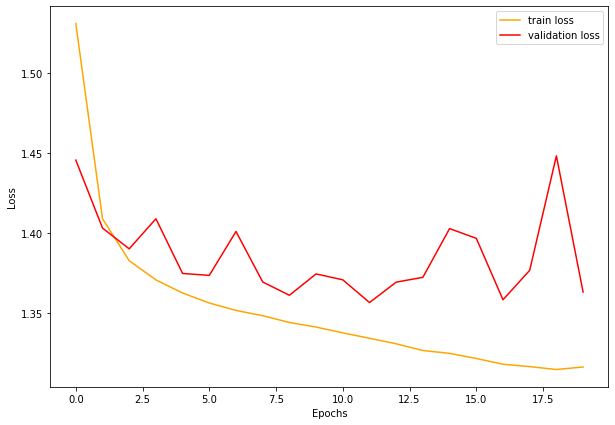

In [23]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss_1, color='orange', label='train loss')
plt.plot(valid_loss_1, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

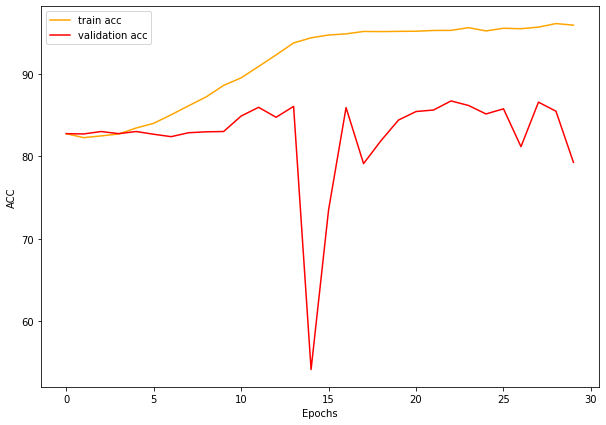

In [24]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_acc_1, color='orange', label='train acc')
plt.plot(valid_acc_1, color='red', label='validation acc')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
plt.show()

## _Model 1 with Augments_

In [25]:
anomalies_to_include_1_aug = [0, 1, 2, 3, 4, 5, 6, 7]
augments_to_include_1_aug = [1, 1, 1, 1]

num_classes_1_aug = len(anomalies_to_include_1_aug)

model_1_aug = ResidualNet('ImageNet', 5, num_classes_1_aug, 'CBAM')
model_1_aug.to(device) # sends model to GPU
optimizer = optim.Adam(model_1_aug.parameters(), lr=0.00003)

train_dataset_1_aug = TeethDataLoader(train_path_to_df, anomalies_to_include_1_aug, True, augments_to_include_1_aug)
valid_dataset_1_aug = TeethDataLoader(valid_path_to_df, anomalies_to_include_1_aug, False, augments_to_include_1_aug)

# generate shuffled sequence of numbers based on how many images, split train/test
train_idx_1_aug = np.array(range(len(train_dataset_1_aug.labels)))
shuffle(train_idx_1_aug)
valid_idx_1_aug = np.array(range(len(valid_dataset_1_aug.labels)))
shuffle(valid_idx_1_aug)

# Samples elements randomly from a given list of indices, without replacement
train_sampler_1_aug = torch.utils.data.SubsetRandomSampler(train_idx_1_aug)
valid_sampler_1_aug = torch.utils.data.SubsetRandomSampler(valid_idx_1_aug)

# loads images associated with ids/samples from above
train_loader_1_aug = torch.utils.data.DataLoader(train_dataset_1_aug, batch_size=batch_size, sampler=train_sampler_1_aug)
valid_loader_1_aug = torch.utils.data.DataLoader(valid_dataset_1_aug, batch_size=batch_size, sampler=valid_sampler_1_aug)

C:\Users\dental-1\AppData\Local\Temp/ipykernel_18448/1289602504.py:123: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.fc.weight)
C:\Users\dental-1\AppData\Local\Temp/ipykernel_18448/1289602504.py:127: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


In [26]:
train_loss_1_aug = []
valid_loss_1_aug = []
train_acc_1_aug = []
valid_acc_1_aug = []

for epoch in range(1, epochs+1):
    train_epoch_loss, train_epoch_accuracy = train(train_loader_1_aug, model_1_aug, num_classes_1_aug, optimizer, epoch)
    valid_epoch_loss, val_epoch_accuracy = valid(valid_loader_1_aug, model_1_aug, num_classes_1_aug, epoch)
    
    train_loss_1_aug.append(train_epoch_loss)
    valid_loss_1_aug.append(valid_epoch_loss)
    
    train_acc_1_aug.append(train_epoch_accuracy)
    valid_acc_1_aug.append(val_epoch_accuracy)

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [01:11<00:00,  3.72it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 1, loss = 1.7528, batch_idx= 266
Epoch: 1 Accuracy of the Train Images: 60.309339
Confusion Matrix
 [[1.600e+01 4.300e+01 1.000e+00 0.000e+00 8.400e+01 0.000e+00 0.000e+00
  1.233e+03]
 [3.200e+01 1.641e+03 0.000e+00 0.000e+00 1.890e+02 0.000e+00 4.500e+01
  9.630e+02]
 [4.000e+00 2.130e+02 0.000e+00 0.000e+00 3.800e+01 0.000e+00 1.100e+01
  1.540e+02]
 [5.000e+00 7.500e+01 0.000e+00 0.000e+00 1.200e+01 0.000e+00 9.000e+00
  9.500e+01]
 [4.000e+00 2.470e+02 0.000e+00 0.000e+00 4.800e+01 0.000e+00 2.500e+01
  4.180e+02]
 [6.000e+00 2.590e+02 0.000e+00 0.000e+00 6.800e+01 0.000e+00 5.200e+01
  4.690e+02]
 [1.500e+01 4.440e+02 0.000e+00 0.000e+00 9.800e+01 0.000e+00 1.330e+02
  8.220e+02]
 [5.600e+01 1.610e+02 1.000e+00 0.000e+00 3.920e+02 0.000e+00 6.000e+00
  8.417e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.12      0.01      0.02      1377
         1.0       0.53      0.57      0.55      2870
         2.0       0.00    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.33it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 1 Accuracy of the Valid Images: 36.470588
Confusion Matrix
 [[0.000e+00 1.770e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.670e+02]
 [0.000e+00 3.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.600e+01]
 [0.000e+00 7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [0.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [0.000e+00 1.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 1.301e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.570e+02]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       344
         1.0       0.02      0.69      0.04        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.06it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 2, loss = 1.5914, batch_idx= 266
Epoch: 2 Accuracy of the Train Images: 68.242766
Confusion Matrix
 [[2.000e+00 2.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+00
  1.348e+03]
 [0.000e+00 2.113e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.480e+02
  6.090e+02]
 [0.000e+00 2.470e+02 7.000e+00 0.000e+00 1.000e+00 0.000e+00 4.500e+01
  1.200e+02]
 [0.000e+00 7.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.700e+01
  7.700e+01]
 [0.000e+00 2.140e+02 0.000e+00 0.000e+00 1.000e+00 0.000e+00 2.190e+02
  3.080e+02]
 [0.000e+00 2.080e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.790e+02
  3.670e+02]
 [0.000e+00 3.390e+02 4.000e+00 0.000e+00 0.000e+00 0.000e+00 5.580e+02
  6.110e+02]
 [0.000e+00 9.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.500e+01
  8.923e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.00      0.00      1377
         1.0       0.64      0.74      0.68      2870
         2.0       0.64    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.26it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 2 Accuracy of the Valid Images: 75.477941
Confusion Matrix
 [[0.000e+00 4.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.020e+02]
 [0.000e+00 2.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+01]
 [0.000e+00 7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.400e+01]
 [1.000e+00 2.090e+02 0.000e+00 0.000e+00 1.000e+01 0.000e+00 7.000e+00
  2.031e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       344
         1.0       0.07      0.41      0.13        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.07it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 3, loss = 1.5376, batch_idx= 266
Epoch: 3 Accuracy of the Train Images: 71.447895
Confusion Matrix
 [[1.000e+01 3.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  1.330e+03]
 [1.000e+00 2.383e+03 4.000e+00 0.000e+00 1.000e+00 0.000e+00 1.480e+02
  3.330e+02]
 [0.000e+00 2.170e+02 6.000e+01 0.000e+00 0.000e+00 0.000e+00 4.400e+01
  9.900e+01]
 [1.000e+00 4.500e+01 0.000e+00 0.000e+00 2.000e+00 1.000e+00 7.800e+01
  6.900e+01]
 [0.000e+00 8.700e+01 2.000e+00 0.000e+00 1.300e+01 9.000e+00 3.430e+02
  2.880e+02]
 [1.000e+00 9.600e+01 0.000e+00 0.000e+00 3.000e+00 1.400e+01 4.050e+02
  3.350e+02]
 [2.000e+00 1.720e+02 6.000e+00 0.000e+00 8.000e+00 2.000e+00 7.620e+02
  5.600e+02]
 [4.000e+00 1.040e+02 5.000e+00 0.000e+00 0.000e+00 0.000e+00 1.300e+01
  8.907e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.53      0.01      0.01      1377
         1.0       0.76      0.83      0.79      2870
         2.0       0.78    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.39it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 3 Accuracy of the Valid Images: 77.389706
Confusion Matrix
 [[0.000e+00 2.900e+01 0.000e+00 0.000e+00 3.000e+00 0.000e+00 8.000e+00
  3.040e+02]
 [0.000e+00 1.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.300e+01]
 [0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  2.300e+01]
 [0.000e+00 6.300e+01 0.000e+00 0.000e+00 2.300e+01 0.000e+00 8.700e+01
  2.085e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       344
         1.0       0.16      0.35      0.22        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.05it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 4, loss = 1.5061, batch_idx= 266
Epoch: 4 Accuracy of the Train Images: 73.270995
Confusion Matrix
 [[9.000e+00 1.700e+01 0.000e+00 0.000e+00 0.000e+00 1.000e+00 2.000e+00
  1.348e+03]
 [0.000e+00 2.542e+03 4.000e+00 0.000e+00 1.000e+00 1.000e+00 1.090e+02
  2.130e+02]
 [0.000e+00 1.780e+02 1.130e+02 0.000e+00 5.000e+00 1.000e+00 4.300e+01
  8.000e+01]
 [0.000e+00 4.500e+01 0.000e+00 0.000e+00 2.000e+00 5.000e+00 7.700e+01
  6.700e+01]
 [0.000e+00 7.000e+01 4.000e+00 0.000e+00 2.200e+01 2.000e+01 3.560e+02
  2.700e+02]
 [0.000e+00 6.900e+01 0.000e+00 0.000e+00 4.000e+00 4.400e+01 4.310e+02
  3.060e+02]
 [1.000e+00 1.320e+02 8.000e+00 0.000e+00 1.000e+01 1.000e+01 8.310e+02
  5.200e+02]
 [2.000e+00 1.020e+02 5.000e+00 0.000e+00 0.000e+00 2.000e+00 2.400e+01
  8.898e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.75      0.01      0.01      1377
         1.0       0.81      0.89      0.84      2870
         2.0       0.84    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.35it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 4 Accuracy of the Valid Images: 54.448529
Confusion Matrix
 [[1.000e+01 1.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.800e+01
  2.670e+02]
 [0.000e+00 1.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e+00
  2.700e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.400e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.000e+00
  1.900e+01]
 [0.000e+00 8.200e+01 0.000e+00 0.000e+00 1.000e+00 0.000e+00 7.290e+02
  1.446e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.03      0.06       344
         1.0       0.15      0.37      0.22        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.06it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 5, loss = 1.4827, batch_idx= 266
Epoch: 5 Accuracy of the Train Images: 74.900024
Confusion Matrix
 [[2.600e+01 1.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.338e+03]
 [3.000e+00 2.629e+03 4.000e+00 0.000e+00 2.000e+00 1.000e+00 1.030e+02
  1.280e+02]
 [0.000e+00 1.370e+02 1.750e+02 0.000e+00 1.000e+01 0.000e+00 3.200e+01
  6.600e+01]
 [0.000e+00 3.700e+01 0.000e+00 0.000e+00 4.000e+00 9.000e+00 8.100e+01
  6.500e+01]
 [0.000e+00 4.300e+01 7.000e+00 0.000e+00 4.000e+01 2.000e+01 3.820e+02
  2.500e+02]
 [0.000e+00 4.300e+01 0.000e+00 0.000e+00 1.000e+01 5.800e+01 4.500e+02
  2.930e+02]
 [1.000e+00 1.110e+02 6.000e+00 0.000e+00 1.000e+01 1.900e+01 8.840e+02
  4.810e+02]
 [5.000e+00 6.500e+01 1.000e+01 0.000e+00 0.000e+00 5.000e+00 2.400e+01
  8.924e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.74      0.02      0.04      1377
         1.0       0.85      0.92      0.88      2870
         2.0       0.87    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.22it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 5 Accuracy of the Valid Images: 75.183824
Confusion Matrix
 [[0.000e+00 9.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.900e+01
  3.060e+02]
 [0.000e+00 9.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  3.900e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.500e+01]
 [0.000e+00 3.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.850e+02
  2.035e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       344
         1.0       0.16      0.18      0.17        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.07it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 6, loss = 1.4613, batch_idx= 266
Epoch: 6 Accuracy of the Train Images: 76.629028
Confusion Matrix
 [[3.400e+01 8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.333e+03]
 [1.000e+00 2.699e+03 4.000e+00 0.000e+00 2.000e+00 0.000e+00 6.700e+01
  9.700e+01]
 [0.000e+00 1.080e+02 2.240e+02 0.000e+00 9.000e+00 1.000e+00 2.900e+01
  4.900e+01]
 [0.000e+00 3.100e+01 0.000e+00 0.000e+00 7.000e+00 1.900e+01 7.800e+01
  6.100e+01]
 [0.000e+00 2.600e+01 2.000e+00 0.000e+00 8.300e+01 2.600e+01 3.800e+02
  2.250e+02]
 [0.000e+00 3.100e+01 0.000e+00 0.000e+00 1.000e+01 1.110e+02 4.490e+02
  2.530e+02]
 [2.000e+00 8.600e+01 8.000e+00 0.000e+00 2.200e+01 3.200e+01 9.460e+02
  4.160e+02]
 [7.000e+00 5.700e+01 6.000e+00 0.000e+00 0.000e+00 2.000e+00 2.800e+01
  8.933e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.77      0.02      0.05      1377
         1.0       0.89      0.94      0.91      2870
         2.0       0.92    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.22it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 6 Accuracy of the Valid Images: 45.147059
Confusion Matrix
 [[0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.31e+02 2.12e+02]
 [0.00e+00 9.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.20e+01 2.00e+01]
 [0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.00e+00 4.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 8.00e+00 6.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.00e+00 1.30e+01]
 [0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 9.00e+00 1.70e+01]
 [0.00e+00 1.70e+01 1.00e+00 0.00e+00 0.00e+00 0.00e+00 1.03e+03 1.21e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       344
         1.0       0.31      0.18      0.23        51
         2.0       0.00      0.00      0.00         8
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00     

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.06it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 7, loss = 1.4421, batch_idx= 266
Epoch: 7 Accuracy of the Train Images: 78.305105
Confusion Matrix
 [[6.200e+01 1.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.304e+03]
 [1.000e+00 2.726e+03 6.000e+00 0.000e+00 3.000e+00 2.000e+00 6.200e+01
  7.000e+01]
 [0.000e+00 6.100e+01 2.800e+02 0.000e+00 1.200e+01 2.000e+00 2.500e+01
  4.000e+01]
 [0.000e+00 3.700e+01 0.000e+00 0.000e+00 7.000e+00 1.700e+01 7.800e+01
  5.700e+01]
 [0.000e+00 2.100e+01 3.000e+00 0.000e+00 1.110e+02 3.100e+01 3.660e+02
  2.100e+02]
 [0.000e+00 2.300e+01 0.000e+00 0.000e+00 1.300e+01 1.370e+02 4.550e+02
  2.260e+02]
 [0.000e+00 6.700e+01 6.000e+00 0.000e+00 2.400e+01 2.300e+01 1.055e+03
  3.370e+02]
 [1.600e+01 4.100e+01 8.000e+00 0.000e+00 0.000e+00 4.000e+00 2.000e+01
  8.944e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.78      0.05      0.09      1377
         1.0       0.91      0.95      0.93      2870
         2.0       0.92    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.29it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 7 Accuracy of the Valid Images: 68.897059
Confusion Matrix
 [[0.000e+00 2.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.700e+01
  2.590e+02]
 [0.000e+00 1.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.000e+00
  2.800e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  7.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.100e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.000e+00
  2.100e+01]
 [0.000e+00 3.300e+01 0.000e+00 0.000e+00 1.000e+00 0.000e+00 3.720e+02
  1.852e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       344
         1.0       0.21      0.31      0.25        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.06it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 8, loss = 1.4247, batch_idx= 266
Epoch: 8 Accuracy of the Train Images: 80.145848
Confusion Matrix
 [[7.500e+01 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.297e+03]
 [0.000e+00 2.769e+03 4.000e+00 0.000e+00 6.000e+00 0.000e+00 4.900e+01
  4.200e+01]
 [0.000e+00 3.200e+01 3.300e+02 0.000e+00 7.000e+00 1.000e+00 2.000e+01
  3.000e+01]
 [0.000e+00 3.600e+01 0.000e+00 0.000e+00 1.100e+01 1.800e+01 7.300e+01
  5.800e+01]
 [0.000e+00 2.200e+01 0.000e+00 0.000e+00 1.720e+02 3.800e+01 3.280e+02
  1.820e+02]
 [0.000e+00 1.600e+01 0.000e+00 0.000e+00 1.600e+01 2.040e+02 4.300e+02
  1.880e+02]
 [0.000e+00 4.600e+01 5.000e+00 0.000e+00 3.800e+01 3.100e+01 1.111e+03
  2.810e+02]
 [1.700e+01 2.800e+01 6.000e+00 0.000e+00 3.000e+00 1.000e+00 1.100e+01
  8.967e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.82      0.05      0.10      1377
         1.0       0.94      0.96      0.95      2870
         2.0       0.96    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.23it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 8 Accuracy of the Valid Images: 40.588235
Confusion Matrix
 [[   0.   28.    0.    0.    0.    4.  113.  199.]
 [   0.   16.    0.    0.    0.    0.   14.   21.]
 [   0.    0.    0.    0.    0.    0.    2.    6.]
 [   0.    0.    0.    0.    0.    0.    0.    3.]
 [   0.    0.    0.    0.    0.    0.    8.    6.]
 [   0.    0.    0.    0.    0.    0.    0.   15.]
 [   0.    3.    0.    0.    0.    0.    8.   16.]
 [   0.  125.    0.    0.    0.   22. 1031. 1080.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       344
         1.0       0.09      0.31      0.14        51
         2.0       0.00      0.00      0.00         8
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00      0.00        14
         5.0       0.00      0.00      0.00        15
         6.0       0.01      0.30      0.01        27
         7.0       0.80      0.48      0.60      2258

    accuracy 

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.07it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 9, loss = 1.4085, batch_idx= 266
Epoch: 9 Accuracy of the Train Images: 81.374971
Confusion Matrix
 [[6.600e+01 7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.304e+03]
 [0.000e+00 2.782e+03 1.000e+00 0.000e+00 1.000e+00 4.000e+00 3.700e+01
  4.500e+01]
 [0.000e+00 1.900e+01 3.560e+02 0.000e+00 6.000e+00 1.000e+00 1.500e+01
  2.300e+01]
 [0.000e+00 3.600e+01 0.000e+00 0.000e+00 1.400e+01 2.300e+01 6.900e+01
  5.400e+01]
 [0.000e+00 9.000e+00 1.000e+00 0.000e+00 2.160e+02 3.900e+01 3.110e+02
  1.660e+02]
 [0.000e+00 1.600e+01 0.000e+00 0.000e+00 2.600e+01 2.570e+02 4.140e+02
  1.410e+02]
 [0.000e+00 4.000e+01 3.000e+00 0.000e+00 3.900e+01 2.900e+01 1.186e+03
  2.150e+02]
 [1.300e+01 2.800e+01 3.000e+00 0.000e+00 2.000e+00 3.000e+00 1.000e+01
  8.974e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.84      0.05      0.09      1377
         1.0       0.95      0.97      0.96      2870
         2.0       0.98    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.18it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 9 Accuracy of the Valid Images: 70.992647
Confusion Matrix
 [[0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 7.000e+00 2.800e+01
  3.080e+02]
 [0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 9.000e+00
  3.800e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  7.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e+00
  2.200e+01]
 [0.000e+00 6.000e+00 0.000e+00 0.000e+00 0.000e+00 1.300e+01 3.170e+02
  1.922e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       344
         1.0       0.36      0.08      0.13        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.06it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 10, loss = 1.3933, batch_idx= 266
Epoch: 10 Accuracy of the Train Images: 83.168666
Confusion Matrix
 [[7.300e+01 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+03]
 [0.000e+00 2.812e+03 3.000e+00 0.000e+00 1.000e+00 1.000e+00 2.600e+01
  2.700e+01]
 [0.000e+00 9.000e+00 3.660e+02 0.000e+00 4.000e+00 2.000e+00 1.600e+01
  2.300e+01]
 [0.000e+00 3.500e+01 0.000e+00 0.000e+00 2.300e+01 2.100e+01 6.100e+01
  5.600e+01]
 [0.000e+00 7.000e+00 0.000e+00 0.000e+00 3.010e+02 3.900e+01 2.610e+02
  1.340e+02]
 [0.000e+00 1.100e+01 0.000e+00 0.000e+00 1.700e+01 3.460e+02 3.570e+02
  1.230e+02]
 [0.000e+00 3.000e+01 4.000e+00 0.000e+00 4.300e+01 3.100e+01 1.254e+03
  1.500e+02]
 [1.300e+01 2.000e+01 3.000e+00 0.000e+00 1.000e+00 1.000e+00 5.000e+00
  8.990e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.85      0.05      0.10      1377
         1.0       0.96      0.98      0.97      2870
         2.0       0.97  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.23it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 10 Accuracy of the Valid Images: 51.286765
Confusion Matrix
 [[4.00e+00 1.70e+01 0.00e+00 0.00e+00 0.00e+00 1.00e+00 7.80e+01 2.44e+02]
 [0.00e+00 1.50e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.30e+01 2.30e+01]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 7.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 6.00e+00 8.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.50e+01]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 6.00e+00 2.10e+01]
 [0.00e+00 5.20e+01 0.00e+00 0.00e+00 0.00e+00 6.00e+00 8.30e+02 1.37e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.01      0.02       344
         1.0       0.18      0.29      0.22        51
         2.0       0.00      0.00      0.00         8
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00    

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.04it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 11, loss = 1.3784, batch_idx= 266
Epoch: 11 Accuracy of the Train Images: 84.480122
Confusion Matrix
 [[9.100e+01 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.281e+03]
 [0.000e+00 2.815e+03 0.000e+00 0.000e+00 0.000e+00 2.000e+00 2.400e+01
  2.900e+01]
 [0.000e+00 6.000e+00 3.750e+02 0.000e+00 7.000e+00 0.000e+00 1.200e+01
  2.000e+01]
 [0.000e+00 3.800e+01 0.000e+00 0.000e+00 2.900e+01 2.400e+01 4.100e+01
  6.400e+01]
 [0.000e+00 6.000e+00 0.000e+00 0.000e+00 3.800e+02 2.300e+01 2.140e+02
  1.190e+02]
 [0.000e+00 7.000e+00 0.000e+00 0.000e+00 1.800e+01 4.390e+02 3.060e+02
  8.400e+01]
 [0.000e+00 1.700e+01 1.000e+00 0.000e+00 5.200e+01 4.600e+01 1.268e+03
  1.280e+02]
 [9.000e+00 1.200e+01 2.000e+00 0.000e+00 1.000e+00 3.000e+00 9.000e+00
  8.997e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.91      0.07      0.12      1377
         1.0       0.97      0.98      0.97      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.26it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 11 Accuracy of the Valid Images: 49.595588
Confusion Matrix
 [[1.000e+00 4.600e+01 0.000e+00 0.000e+00 0.000e+00 1.500e+01 6.600e+01
  2.160e+02]
 [0.000e+00 1.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.500e+01
  2.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  7.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 6.000e+00
  1.600e+01]
 [0.000e+00 2.260e+02 0.000e+00 0.000e+00 0.000e+00 5.500e+01 6.510e+02
  1.326e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.00      0.01       344
         1.0       0.05      0.27      0.08        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.07it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 12, loss = 1.3653, batch_idx= 266
Epoch: 12 Accuracy of the Train Images: 85.891555
Confusion Matrix
 [[6.700e+01 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.308e+03]
 [0.000e+00 2.842e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.600e+01
  1.200e+01]
 [0.000e+00 5.000e+00 3.860e+02 0.000e+00 7.000e+00 1.000e+00 1.000e+01
  1.100e+01]
 [0.000e+00 3.300e+01 1.000e+00 0.000e+00 3.000e+01 2.700e+01 4.300e+01
  6.200e+01]
 [0.000e+00 5.000e+00 0.000e+00 0.000e+00 4.600e+02 3.200e+01 1.510e+02
  9.400e+01]
 [0.000e+00 3.000e+00 0.000e+00 0.000e+00 1.800e+01 5.210e+02 2.570e+02
  5.500e+01]
 [0.000e+00 1.700e+01 0.000e+00 0.000e+00 3.800e+01 5.500e+01 1.322e+03
  8.000e+01]
 [9.000e+00 1.400e+01 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
  9.007e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.88      0.05      0.09      1377
         1.0       0.97      0.99      0.98      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.24it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 12 Accuracy of the Valid Images: 66.139706
Confusion Matrix
 [[0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 3.300e+01
  3.080e+02]
 [0.000e+00 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.300e+01
  3.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  6.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  1.100e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  2.500e+01]
 [0.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+00 4.590e+02
  1.792e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       344
         1.0       0.56      0.10      0.17        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.05it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 13, loss = 1.3546, batch_idx= 266
Epoch: 13 Accuracy of the Train Images: 86.926606
Confusion Matrix
 [[5.300e+01 2.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  1.321e+03]
 [0.000e+00 2.845e+03 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.200e+01
  1.200e+01]
 [0.000e+00 0.000e+00 3.890e+02 0.000e+00 6.000e+00 0.000e+00 1.300e+01
  1.200e+01]
 [0.000e+00 3.400e+01 0.000e+00 0.000e+00 3.500e+01 2.500e+01 4.000e+01
  6.200e+01]
 [0.000e+00 3.000e+00 0.000e+00 0.000e+00 5.310e+02 2.500e+01 1.090e+02
  7.400e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.100e+01 5.950e+02 2.090e+02
  3.800e+01]
 [0.000e+00 1.100e+01 2.000e+00 0.000e+00 3.400e+01 4.300e+01 1.362e+03
  6.000e+01]
 [6.000e+00 1.300e+01 2.000e+00 0.000e+00 0.000e+00 0.000e+00 6.000e+00
  9.006e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.90      0.04      0.07      1377
         1.0       0.98      0.99      0.98      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.29it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 13 Accuracy of the Valid Images: 34.448529
Confusion Matrix
 [[  6. 102.   0.   0.   0.   0.  97. 139.]
 [  0.  24.   0.   0.   0.   0.  18.   9.]
 [  0.   1.   0.   0.   0.   0.   5.   2.]
 [  0.   0.   0.   0.   0.   0.   1.   2.]
 [  0.   2.   0.   0.   0.   0.   6.   6.]
 [  0.   0.   0.   0.   0.   2.   0.  13.]
 [  0.   7.   0.   0.   0.   0.   7.  13.]
 [  2. 393.   0.   0.   0.  17. 948. 898.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.75      0.02      0.03       344
         1.0       0.05      0.47      0.08        51
         2.0       0.00      0.00      0.00         8
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00      0.00        14
         5.0       0.11      0.13      0.12        15
         6.0       0.01      0.26      0.01        27
         7.0       0.83      0.40      0.54      2258

    accuracy                           0.34      2720
   macro avg       0.2

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.08it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 14, loss = 1.3460, batch_idx= 266
Epoch: 14 Accuracy of the Train Images: 87.832275
Confusion Matrix
 [[5.000e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.326e+03]
 [0.000e+00 2.850e+03 0.000e+00 0.000e+00 0.000e+00 2.000e+00 1.100e+01
  7.000e+00]
 [0.000e+00 1.000e+00 3.950e+02 0.000e+00 1.000e+01 0.000e+00 7.000e+00
  7.000e+00]
 [0.000e+00 3.700e+01 1.000e+00 0.000e+00 3.200e+01 2.300e+01 3.900e+01
  6.400e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 5.850e+02 1.400e+01 8.400e+01
  5.800e+01]
 [0.000e+00 4.000e+00 0.000e+00 0.000e+00 5.000e+00 6.390e+02 1.730e+02
  3.300e+01]
 [0.000e+00 4.000e+00 2.000e+00 0.000e+00 3.000e+01 2.900e+01 1.401e+03
  4.600e+01]
 [5.000e+00 6.000e+00 1.000e+00 0.000e+00 1.000e+00 2.000e+00 3.000e+00
  9.015e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.91      0.04      0.07      1377
         1.0       0.98      0.99      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.27it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 14 Accuracy of the Valid Images: 58.713235
Confusion Matrix
 [[1.000e+01 1.000e+01 0.000e+00 0.000e+00 0.000e+00 2.000e+01 7.700e+01
  2.270e+02]
 [0.000e+00 6.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 2.000e+01
  2.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+00
  1.000e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 1.000e+00
  1.200e+01]
 [0.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 8.000e+00
  1.500e+01]
 [2.000e+00 7.400e+01 0.000e+00 0.000e+00 0.000e+00 1.430e+02 4.680e+02
  1.571e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.83      0.03      0.06       344
         1.0       0.06      0.12      0.08        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.06it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 15, loss = 1.3370, batch_idx= 266
Epoch: 15 Accuracy of the Train Images: 88.632087
Confusion Matrix
 [[5.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.321e+03]
 [0.000e+00 2.859e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 3.960e+02 0.000e+00 9.000e+00 0.000e+00 7.000e+00
  8.000e+00]
 [0.000e+00 3.500e+01 0.000e+00 0.000e+00 3.600e+01 2.300e+01 4.100e+01
  6.100e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 6.220e+02 1.400e+01 6.900e+01
  3.600e+01]
 [0.000e+00 3.000e+00 0.000e+00 0.000e+00 5.000e+00 6.900e+02 1.370e+02
  1.900e+01]
 [0.000e+00 6.000e+00 0.000e+00 0.000e+00 1.800e+01 2.000e+01 1.431e+03
  3.700e+01]
 [3.000e+00 9.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  9.017e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.95      0.04      0.08      1377
         1.0       0.98      1.00      0.99      2870
         2.0       1.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.24it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 15 Accuracy of the Valid Images: 40.257353
Confusion Matrix
 [[2.000e+01 8.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 9.700e+01
  1.460e+02]
 [0.000e+00 2.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.200e+01
  9.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.000e+00
  1.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.000e+00
  7.000e+00]
 [0.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [0.000e+00 6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 9.000e+00
  1.200e+01]
 [3.000e+00 4.790e+02 0.000e+00 0.000e+00 0.000e+00 1.000e+00 7.290e+02
  1.046e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.87      0.06      0.11       344
         1.0       0.03      0.39      0.06        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.06it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 16, loss = 1.3307, batch_idx= 266
Epoch: 16 Accuracy of the Train Images: 89.067278
Confusion Matrix
 [[4.400e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.332e+03]
 [0.000e+00 2.862e+03 0.000e+00 0.000e+00 0.000e+00 1.000e+00 2.000e+00
  5.000e+00]
 [0.000e+00 0.000e+00 3.980e+02 0.000e+00 8.000e+00 0.000e+00 5.000e+00
  9.000e+00]
 [0.000e+00 4.100e+01 1.000e+00 0.000e+00 3.500e+01 2.000e+01 3.700e+01
  6.200e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 6.650e+02 8.000e+00 4.400e+01
  2.400e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 2.000e+00 7.210e+02 1.120e+02
  1.700e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 1.700e+01 2.700e+01 1.435e+03
  3.100e+01]
 [3.000e+00 5.000e+00 1.000e+00 0.000e+00 0.000e+00 2.000e+00 2.000e+00
  9.020e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.94      0.03      0.06      1377
         1.0       0.98      1.00      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.21it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 16 Accuracy of the Valid Images: 53.014706
Confusion Matrix
 [[1.700e+01 3.200e+01 0.000e+00 0.000e+00 0.000e+00 7.000e+00 2.700e+01
  2.610e+02]
 [0.000e+00 9.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 1.000e+01
  2.900e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  7.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  1.100e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00
  1.200e+01]
 [0.000e+00 5.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 2.000e+00
  1.900e+01]
 [3.000e+00 2.550e+02 0.000e+00 0.000e+00 0.000e+00 1.380e+02 4.500e+02
  1.412e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.85      0.05      0.09       344
         1.0       0.03      0.18      0.05        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.08it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 17, loss = 1.3241, batch_idx= 266
Epoch: 17 Accuracy of the Train Images: 89.602446
Confusion Matrix
 [[3.400e+01 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.341e+03]
 [0.000e+00 2.866e+03 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 4.020e+02 0.000e+00 9.000e+00 0.000e+00 4.000e+00
  5.000e+00]
 [0.000e+00 3.600e+01 1.000e+00 0.000e+00 3.100e+01 1.900e+01 4.700e+01
  6.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.950e+02 6.000e+00 2.000e+01
  2.100e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 7.540e+02 8.700e+01
  1.100e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 6.000e+00 1.900e+01 1.461e+03
  2.400e+01]
 [0.000e+00 4.000e+00 1.000e+00 0.000e+00 0.000e+00 2.000e+00 2.000e+00
  9.024e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.02      0.05      1377
         1.0       0.98      1.00      0.99      2870
         2.0       1.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.29it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 17 Accuracy of the Valid Images: 66.948529
Confusion Matrix
 [[1.80e+01 6.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 3.00e+01 2.89e+02]
 [0.00e+00 1.20e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.30e+01 2.60e+01]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.00e+00 5.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.00e+00 1.20e+01]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 1.40e+01]
 [0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 2.40e+01]
 [2.00e+00 4.00e+01 0.00e+00 0.00e+00 0.00e+00 1.50e+01 4.11e+02 1.79e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.90      0.05      0.10       344
         1.0       0.20      0.24      0.22        51
         2.0       0.00      0.00      0.00         8
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00    

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.08it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 18, loss = 1.3202, batch_idx= 266
Epoch: 18 Accuracy of the Train Images: 89.837685
Confusion Matrix
 [[2.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.348e+03]
 [0.000e+00 2.863e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 4.050e+02 0.000e+00 7.000e+00 1.000e+00 3.000e+00
  4.000e+00]
 [0.000e+00 3.300e+01 2.000e+00 0.000e+00 3.700e+01 2.400e+01 3.900e+01
  6.100e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.060e+02 3.000e+00 2.000e+01
  1.300e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 1.000e+00 7.710e+02 6.900e+01
  1.100e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 4.000e+00 1.200e+01 1.477e+03
  1.700e+01]
 [0.000e+00 4.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 2.000e+00
  9.026e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.02      0.04      1377
         1.0       0.99      1.00      0.99      2870
         2.0       1.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.20it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 18 Accuracy of the Valid Images: 70.330882
Confusion Matrix
 [[8.900e+01 1.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.000e+00
  2.340e+02]
 [0.000e+00 1.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  3.700e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  7.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.200e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [2.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.100e+01]
 [1.910e+02 1.550e+02 0.000e+00 0.000e+00 0.000e+00 4.000e+00 9.600e+01
  1.812e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.31      0.26      0.28       344
         1.0       0.06      0.22      0.09        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.06it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 19, loss = 1.3150, batch_idx= 266
Epoch: 19 Accuracy of the Train Images: 90.172900
Confusion Matrix
 [[2.500e+01 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.349e+03]
 [0.000e+00 2.868e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00]
 [0.000e+00 0.000e+00 4.040e+02 0.000e+00 5.000e+00 0.000e+00 6.000e+00
  5.000e+00]
 [0.000e+00 3.900e+01 3.000e+00 0.000e+00 3.800e+01 1.700e+01 3.800e+01
  6.100e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.260e+02 0.000e+00 5.000e+00
  1.100e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 7.890e+02 5.300e+01
  1.100e+01]
 [0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 6.000e+00 1.497e+03
  8.000e+00]
 [1.000e+00 5.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 1.000e+00
  9.024e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.96      0.02      0.04      1377
         1.0       0.98      1.00      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.28it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 19 Accuracy of the Valid Images: 77.205882
Confusion Matrix
 [[1.300e+01 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+01
  3.160e+02]
 [0.000e+00 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.000e+00
  3.900e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  5.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.400e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  2.400e+01]
 [1.000e+00 5.800e+01 0.000e+00 0.000e+00 0.000e+00 1.100e+01 1.060e+02
  2.082e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.93      0.04      0.07       344
         1.0       0.07      0.10      0.08        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.06it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 20, loss = 1.3131, batch_idx= 266
Epoch: 20 Accuracy of the Train Images: 90.278758
Confusion Matrix
 [[3.200e+01 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.343e+03]
 [0.000e+00 2.867e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.000e+00]
 [0.000e+00 0.000e+00 4.090e+02 0.000e+00 3.000e+00 1.000e+00 2.000e+00
  5.000e+00]
 [0.000e+00 3.500e+01 5.000e+00 0.000e+00 3.500e+01 2.500e+01 4.000e+01
  5.600e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.230e+02 0.000e+00 8.000e+00
  1.100e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 8.040e+02 4.400e+01
  6.000e+00]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 2.000e+00 5.000e+00 1.491e+03
  1.200e+01]
 [0.000e+00 2.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 4.000e+00
  9.025e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.02      0.05      1377
         1.0       0.99      1.00      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.29it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 20 Accuracy of the Valid Images: 71.654412
Confusion Matrix
 [[1.800e+01 3.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+01
  2.770e+02]
 [0.000e+00 1.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.000e+00
  3.000e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.300e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.200e+01]
 [1.000e+00 2.080e+02 0.000e+00 0.000e+00 0.000e+00 3.000e+00 1.310e+02
  1.915e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.95      0.05      0.10       344
         1.0       0.06      0.29      0.09        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.08it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 21, loss = 1.3100, batch_idx= 266
Epoch: 21 Accuracy of the Train Images: 90.431663
Confusion Matrix
 [[2.400e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.351e+03]
 [0.000e+00 2.867e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.000e+00]
 [0.000e+00 0.000e+00 4.070e+02 0.000e+00 5.000e+00 0.000e+00 2.000e+00
  6.000e+00]
 [0.000e+00 4.200e+01 4.000e+00 0.000e+00 3.000e+01 2.200e+01 3.900e+01
  5.900e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.330e+02 0.000e+00 3.000e+00
  6.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 8.220e+02 2.700e+01
  4.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 5.000e+00 1.497e+03
  8.000e+00]
 [0.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  9.027e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.02      0.03      1377
         1.0       0.98      1.00      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.29it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 21 Accuracy of the Valid Images: 71.102941
Confusion Matrix
 [[9.800e+01 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e+00
  2.370e+02]
 [0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.000e+00
  4.100e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  6.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.200e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.200e+01]
 [3.350e+02 2.200e+01 0.000e+00 0.000e+00 0.000e+00 1.000e+00 6.900e+01
  1.831e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.22      0.28      0.25       344
         1.0       0.13      0.08      0.10        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.08it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 22, loss = 1.3093, batch_idx= 266
Epoch: 22 Accuracy of the Train Images: 90.525759
Confusion Matrix
 [[2.900e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.346e+03]
 [0.000e+00 2.866e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 4.130e+02 0.000e+00 1.000e+00 0.000e+00 3.000e+00
  3.000e+00]
 [0.000e+00 4.100e+01 4.000e+00 0.000e+00 3.800e+01 2.600e+01 3.600e+01
  5.100e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.350e+02 0.000e+00 2.000e+00
  5.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 8.230e+02 2.200e+01
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 1.499e+03
  1.100e+01]
 [0.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  9.028e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.02      0.04      1377
         1.0       0.98      1.00      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.19it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 22 Accuracy of the Valid Images: 77.683824
Confusion Matrix
 [[1.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 7.000e+00
  3.170e+02]
 [0.000e+00 9.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.000e+00
  3.600e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  6.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  2.500e+01]
 [1.000e+00 6.000e+00 0.000e+00 0.000e+00 0.000e+00 7.000e+00 1.610e+02
  2.083e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.95      0.06      0.10       344
         1.0       0.60      0.18      0.27        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.07it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 23, loss = 1.3066, batch_idx= 266
Epoch: 23 Accuracy of the Train Images: 90.578687
Confusion Matrix
 [[1.600e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.360e+03]
 [0.000e+00 2.868e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00]
 [0.000e+00 0.000e+00 4.140e+02 0.000e+00 1.000e+00 0.000e+00 3.000e+00
  2.000e+00]
 [0.000e+00 3.800e+01 2.000e+00 0.000e+00 2.800e+01 2.900e+01 3.900e+01
  6.000e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.360e+02 0.000e+00 1.000e+00
  5.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 8.370e+02 1.300e+01
  3.000e+00]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 1.500e+03
  8.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  9.031e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.01      0.02      1377
         1.0       0.99      1.00      0.99      2870
         2.0       1.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.29it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 23 Accuracy of the Valid Images: 58.970588
Confusion Matrix
 [[7.000e+00 6.000e+00 0.000e+00 0.000e+00 0.000e+00 3.600e+01 5.100e+01
  2.440e+02]
 [0.000e+00 8.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 1.500e+01
  2.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  5.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 3.000e+00
  1.000e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+00 1.000e+00
  1.000e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 7.000e+00
  1.600e+01]
 [1.000e+00 3.800e+01 0.000e+00 0.000e+00 0.000e+00 2.500e+02 3.910e+02
  1.578e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.88      0.02      0.04       344
         1.0       0.15      0.16      0.15        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.06it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 24, loss = 1.3065, batch_idx= 266
Epoch: 24 Accuracy of the Train Images: 90.631616
Confusion Matrix
 [[2.500e+01 2.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  1.349e+03]
 [0.000e+00 2.869e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00]
 [0.000e+00 0.000e+00 4.140e+02 0.000e+00 3.000e+00 0.000e+00 1.000e+00
  2.000e+00]
 [1.000e+00 4.000e+01 8.000e+00 0.000e+00 3.700e+01 2.400e+01 3.300e+01
  5.300e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 7.360e+02 0.000e+00 1.000e+00
  4.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 8.420e+02 9.000e+00
  2.000e+00]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 1.498e+03
  9.000e+00]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+00
  9.027e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.96      0.02      0.04      1377
         1.0       0.98      1.00      0.99      2870
         2.0       0.98  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.41it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 24 Accuracy of the Valid Images: 64.705882
Confusion Matrix
 [[3.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.700e+01
  3.110e+02]
 [0.000e+00 8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.300e+01
  3.000e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  6.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+00
  1.000e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.400e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e+00
  2.100e+01]
 [1.000e+00 6.300e+01 0.000e+00 0.000e+00 0.000e+00 4.000e+00 4.460e+02
  1.744e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.75      0.01      0.02       344
         1.0       0.11      0.16      0.13        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.07it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 25, loss = 1.3057, batch_idx= 266
Epoch: 25 Accuracy of the Train Images: 90.690426
Confusion Matrix
 [[2.800e+01 3.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  1.345e+03]
 [0.000e+00 2.868e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00]
 [0.000e+00 0.000e+00 4.170e+02 0.000e+00 2.000e+00 0.000e+00 1.000e+00
  0.000e+00]
 [0.000e+00 4.500e+01 3.000e+00 0.000e+00 2.800e+01 3.000e+01 3.300e+01
  5.700e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.360e+02 0.000e+00 1.000e+00
  5.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 8.410e+02 1.100e+01
  2.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.505e+03
  5.000e+00]
 [1.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  9.026e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.97      0.02      0.04      1377
         1.0       0.98      1.00      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.38it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 25 Accuracy of the Valid Images: 72.573529
Confusion Matrix
 [[6.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.600e+01
  3.210e+02]
 [0.000e+00 1.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.000e+00
  3.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  6.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  2.500e+01]
 [1.000e+00 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.960e+02
  1.956e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.86      0.02      0.03       344
         1.0       0.62      0.20      0.30        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.05it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 26, loss = 1.3054, batch_idx= 266
Epoch: 26 Accuracy of the Train Images: 90.784521
Confusion Matrix
 [[3.800e+01 2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.336e+03]
 [0.000e+00 2.869e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00]
 [0.000e+00 0.000e+00 4.160e+02 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  2.000e+00]
 [0.000e+00 3.600e+01 4.000e+00 0.000e+00 4.100e+01 3.400e+01 3.000e+01
  5.100e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.380e+02 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 8.460e+02 6.000e+00
  1.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e+00 1.502e+03
  5.000e+00]
 [1.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  9.028e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.97      0.03      0.05      1377
         1.0       0.99      1.00      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.27it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 26 Accuracy of the Valid Images: 77.610294
Confusion Matrix
 [[1.000e+00 1.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.000e+00
  3.230e+02]
 [0.000e+00 1.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  3.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  5.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  2.500e+01]
 [1.000e+00 6.100e+01 0.000e+00 0.000e+00 0.000e+00 1.100e+01 9.000e+01
  2.095e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.50      0.00      0.01       344
         1.0       0.17      0.29      0.21        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.07it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 27, loss = 1.3026, batch_idx= 266
Epoch: 27 Accuracy of the Train Images: 90.860974
Confusion Matrix
 [[3.300e+01 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.341e+03]
 [0.000e+00 2.869e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00]
 [0.000e+00 0.000e+00 4.200e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [0.000e+00 3.200e+01 1.000e+01 0.000e+00 3.700e+01 2.700e+01 3.300e+01
  5.700e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.390e+02 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 8.520e+02 1.000e+00
  1.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.506e+03
  6.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  9.031e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.02      0.05      1377
         1.0       0.99      1.00      0.99      2870
         2.0       0.98  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.33it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 27 Accuracy of the Valid Images: 78.529412
Confusion Matrix
 [[2.000e+00 1.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.000e+00
  3.190e+02]
 [0.000e+00 1.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.000e+00
  3.000e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.400e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.500e+01]
 [0.000e+00 8.100e+01 0.000e+00 0.000e+00 0.000e+00 3.000e+00 5.500e+01
  2.119e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.01      0.01       344
         1.0       0.13      0.29      0.18        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.09it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 28, loss = 1.3030, batch_idx= 266
Epoch: 28 Accuracy of the Train Images: 90.925665
Confusion Matrix
 [[4.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
  1.331e+03]
 [0.000e+00 2.868e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00]
 [0.000e+00 0.000e+00 4.200e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [0.000e+00 3.100e+01 5.000e+00 0.000e+00 3.700e+01 3.300e+01 3.600e+01
  5.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.390e+02 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 8.530e+02 0.000e+00
  0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.506e+03
  6.000e+00]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.031e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.03      0.06      1377
         1.0       0.99      1.00      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.34it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 28 Accuracy of the Valid Images: 78.786765
Confusion Matrix
 [[1.000e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e+00
  3.280e+02]
 [0.000e+00 6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e+00
  4.000e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  6.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.600e+01]
 [1.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 7.000e+00 1.200e+02
  2.126e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.91      0.03      0.06       344
         1.0       0.55      0.12      0.19        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.07it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 29, loss = 1.3024, batch_idx= 266
Epoch: 29 Accuracy of the Train Images: 90.937426
Confusion Matrix
 [[4.700e+01 2.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.325e+03]
 [0.000e+00 2.869e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00]
 [0.000e+00 0.000e+00 4.200e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [0.000e+00 3.700e+01 5.000e+00 0.000e+00 3.200e+01 3.900e+01 3.200e+01
  5.100e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 7.380e+02 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 8.500e+02 1.000e+00
  2.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.508e+03
  4.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  9.031e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.03      0.07      1377
         1.0       0.99      1.00      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.32it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 29 Accuracy of the Valid Images: 69.264706
Confusion Matrix
 [[7.000e+00 3.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.500e+01
  2.830e+02]
 [0.000e+00 2.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 6.000e+00
  2.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  5.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.300e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.400e+01]
 [0.000e+00 2.360e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.680e+02
  1.854e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.02      0.04       344
         1.0       0.08      0.45      0.13        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:52<00:00,  5.06it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 30, loss = 1.3044, batch_idx= 266
Epoch: 30 Accuracy of the Train Images: 90.855093
Confusion Matrix
 [[6.100e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  1.312e+03]
 [0.000e+00 2.865e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 4.170e+02 0.000e+00 0.000e+00 2.000e+00 0.000e+00
  1.000e+00]
 [0.000e+00 3.700e+01 2.000e+00 0.000e+00 4.500e+01 3.000e+01 3.600e+01
  4.600e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.350e+02 0.000e+00 2.000e+00
  5.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 8.470e+02 3.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 1.497e+03
  1.200e+01]
 [2.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  9.027e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.97      0.04      0.08      1377
         1.0       0.99      1.00      0.99      2870
         2.0       1.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  8.32it/s]


Epoch: 30 Accuracy of the Valid Images: 75.404412
Confusion Matrix
 [[1.400e+01 2.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  3.010e+02]
 [0.000e+00 1.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  3.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  7.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.300e+01]
 [0.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.300e+01]
 [1.000e+00 1.930e+02 0.000e+00 0.000e+00 0.000e+00 1.000e+00 4.500e+01
  2.018e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.93      0.04      0.08       344
         1.0       0.07      0.35      0.12        51
         2.0       0.00      0.00      0.00         8
         3.

C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

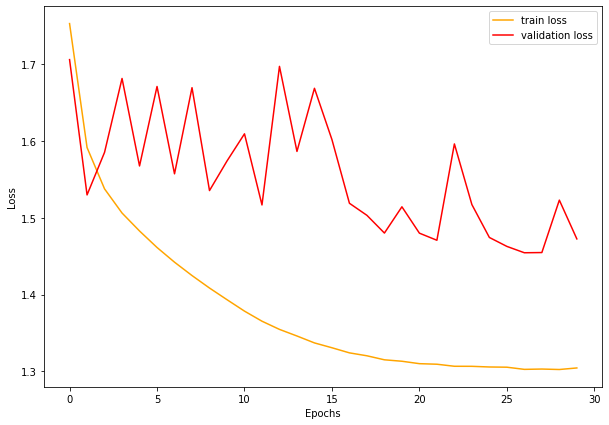

In [27]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss_1_aug, color='orange', label='train loss')
plt.plot(valid_loss_1_aug, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

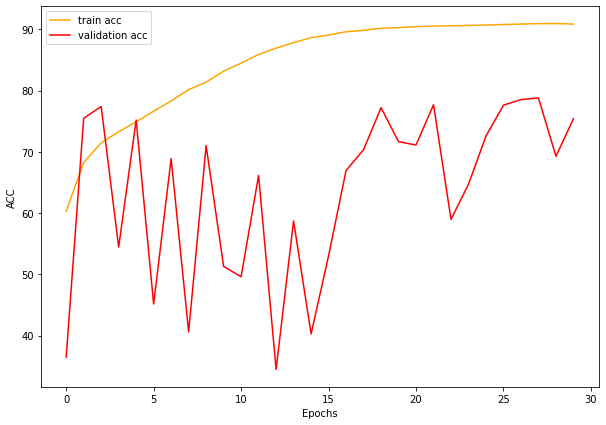

In [28]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_acc_1_aug, color='orange', label='train acc')
plt.plot(valid_acc_1_aug, color='red', label='validation acc')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
plt.show()

## _Model 1 with Clahe_

In [29]:
anomalies_to_include_1 = [0, 1, 2, 3, 4, 5, 6, 7]
augments_to_include_1 = [0, 0, 0, 0]

num_classes_1 = len(anomalies_to_include_1)

model_1 = ResidualNet('ImageNet', 5, num_classes_1, 'CBAM')
model_1.to(device) # sends model to GPU
optimizer = optim.Adam(model_1.parameters(), lr=0.00003)

train_dataset_1 = TeethDataLoader(train_clahe_path_to_df, anomalies_to_include_1, True, augments_to_include_1)
valid_dataset_1 = TeethDataLoader(valid_clahe_path_to_df, anomalies_to_include_1, False, augments_to_include_1)

# generate shuffled sequence of numbers based on how many images, split train/test
train_idx_1 = np.array(range(len(train_dataset_1.labels)))
shuffle(train_idx_1)
valid_idx_1 = np.array(range(len(valid_dataset_1.labels)))
shuffle(valid_idx_1)

# Samples elements randomly from a given list of indices, without replacement
train_sampler_1 = torch.utils.data.SubsetRandomSampler(train_idx_1)
valid_sampler_1 = torch.utils.data.SubsetRandomSampler(valid_idx_1)

# loads images associated with ids/samples from above
train_loader_1 = torch.utils.data.DataLoader(train_dataset_1, batch_size=batch_size, sampler=train_sampler_1)
valid_loader_1 = torch.utils.data.DataLoader(valid_dataset_1, batch_size=batch_size, sampler=valid_sampler_1)

C:\Users\dental-1\AppData\Local\Temp/ipykernel_18448/1289602504.py:123: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.fc.weight)
C:\Users\dental-1\AppData\Local\Temp/ipykernel_18448/1289602504.py:127: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


In [30]:
train_loss_1 = []
valid_loss_1 = []
train_acc_1 = []
valid_acc_1 = []

for epoch in range(1, epochs+1):
    train_epoch_loss, train_epoch_accuracy = train(train_loader_1, model_1, num_classes_1, optimizer, epoch)
    valid_epoch_loss, val_epoch_accuracy = valid(valid_loader_1, model_1, num_classes_1, epoch)
    
    train_loss_1.append(train_epoch_loss)
    valid_loss_1.append(valid_epoch_loss)
    
    train_acc_1.append(train_epoch_accuracy)
    valid_acc_1.append(val_epoch_accuracy)

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:34<00:00,  5.02it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 1, loss = 1.7102, batch_idx= 171
Epoch: 1 Accuracy of the Train Images: 71.381307
Confusion Matrix
 [[1.310e+02 1.800e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.066e+03]
 [2.000e+01 3.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.540e+02]
 [1.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.500e+01]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+01]
 [2.000e+00 9.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.200e+01]
 [4.000e+00 8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.900e+01]
 [9.000e+00 1.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.100e+01]
 [4.250e+02 9.980e+02 0.000e+00 1.000e+00 2.000e+00 1.000e+00 1.000e+00
  7.605e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.22      0.10      0.13      1377
         1.0       0.02      0.15      0.04       205
         2.0       0.00    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  7.37it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 1 Accuracy of the Valid Images: 83.014706
Confusion Matrix
 [[   3.    0.    0.    0.    0.    0.    0.  341.]
 [   0.    0.    0.    0.    0.    0.    0.   51.]
 [   0.    0.    0.    0.    0.    0.    0.    8.]
 [   0.    0.    0.    0.    0.    0.    0.    3.]
 [   0.    0.    0.    0.    0.    0.    0.   14.]
 [   0.    0.    0.    0.    0.    0.    0.   15.]
 [   0.    0.    0.    0.    0.    0.    0.   27.]
 [   3.    0.    0.    0.    0.    0.    0. 2255.]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.50      0.01      0.02       344
         1.0       0.00      0.00      0.00        51
         2.0       0.00      0.00      0.00         8
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00      0.00        14
         5.0       0.00      0.00      0.00        15
         6.0       0.00      0.00      0.00        27
         7.0       0.83      1.00      0.91      2258

    accuracy 

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:34<00:00,  5.00it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 2, loss = 1.4915, batch_idx= 171
Epoch: 2 Accuracy of the Train Images: 81.499862
Confusion Matrix
 [[2.050e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.172e+03]
 [2.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.800e+02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.100e+01]
 [4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.900e+01]
 [8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.300e+01]
 [6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.020e+02]
 [3.700e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.663e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.33      0.15      0.21      1377
         1.0       0.00      0.00      0.00       205
         2.0       0.00    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  7.52it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 2 Accuracy of the Valid Images: 81.507353
Confusion Matrix
 [[5.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.940e+02]
 [6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.400e+01]
 [9.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.167e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.32      0.15      0.20       344
         1.0       0.00      0.00      0.00        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:34<00:00,  5.02it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 3, loss = 1.4488, batch_idx= 171
Epoch: 3 Accuracy of the Train Images: 80.856539
Confusion Matrix
 [[2.620e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.115e+03]
 [2.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.760e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.900e+01]
 [4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+01]
 [6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.700e+01]
 [9.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.200e+01]
 [8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+02]
 [4.970e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.536e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.32      0.19      0.24      1377
         1.0       0.00      0.00      0.00       205
         2.0       0.00    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.13it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 3 Accuracy of the Valid Images: 82.683824
Confusion Matrix
 [[3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.410e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [1.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.246e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.19      0.01      0.02       344
         1.0       0.00      0.00      0.00        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.85it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 4, loss = 1.4364, batch_idx= 171
Epoch: 4 Accuracy of the Train Images: 81.187391
Confusion Matrix
 [[2.460e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.131e+03]
 [3.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.740e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.900e+01]
 [4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+01]
 [4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.900e+01]
 [4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.700e+01]
 [8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+02]
 [4.450e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.588e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.33      0.18      0.23      1377
         1.0       0.00      0.00      0.00       205
         2.0       0.00    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.15it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 4 Accuracy of the Valid Images: 82.867647
Confusion Matrix
 [[5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.390e+02]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.900e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [9.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.249e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.31      0.01      0.03       344
         1.0       0.00      0.00      0.00        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.84it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 5, loss = 1.4190, batch_idx= 171
Epoch: 5 Accuracy of the Train Images: 82.179947
Confusion Matrix
 [[2.290e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.148e+03]
 [3.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.680e+02]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.900e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.800e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.800e+01]
 [7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [3.200e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.713e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.38      0.17      0.23      1377
         1.0       0.00      0.00      0.00       205
         2.0       0.00    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.07it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 5 Accuracy of the Valid Images: 79.264706
Confusion Matrix
 [[1.56e+02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.88e+02]
 [1.80e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.30e+01]
 [1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 7.00e+00]
 [1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.00e+00]
 [4.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+01]
 [4.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.10e+01]
 [4.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.30e+01]
 [2.58e+02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.00e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.35      0.45      0.39       344
         1.0       0.00      0.00      0.00        51
         2.0       0.00      0.00      0.00         8
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00     

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.84it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 6, loss = 1.4090, batch_idx= 171
Epoch: 6 Accuracy of the Train Images: 83.439022
Confusion Matrix
 [[2.810e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.096e+03]
 [3.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.710e+02]
 [4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.600e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.200e+01]
 [4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.700e+01]
 [5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.030e+02]
 [2.350e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.798e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.50      0.20      0.29      1377
         1.0       0.00      0.00      0.00       205
         2.0       0.00    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.06it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 6 Accuracy of the Valid Images: 83.933824
Confusion Matrix
 [[4.30e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.01e+02]
 [9.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 4.20e+01]
 [1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 7.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.40e+01]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.50e+01]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.70e+01]
 [1.80e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.24e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.61      0.12      0.21       344
         1.0       0.00      0.00      0.00        51
         2.0       0.00      0.00      0.00         8
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00     

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.83it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 7, loss = 1.4050, batch_idx= 171
Epoch: 7 Accuracy of the Train Images: 84.238581
Confusion Matrix
 [[3.190e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.058e+03]
 [4.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.570e+02]
 [4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.600e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.200e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+01]
 [5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.030e+02]
 [1.850e+02 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.847e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.57      0.23      0.33      1377
         1.0       0.00      0.00      0.00       205
         2.0       0.00    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.92it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 7 Accuracy of the Valid Images: 81.213235
Confusion Matrix
 [[2.160e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.280e+02]
 [1.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.200e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00]
 [6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+01]
 [6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.100e+01]
 [2.650e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.993e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.41      0.63      0.50       344
         1.0       0.00      0.00      0.00        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.84it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 8, loss = 1.3967, batch_idx= 171
Epoch: 8 Accuracy of the Train Images: 85.056521
Confusion Matrix
 [[4.870e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.900e+02]
 [4.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.580e+02]
 [6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.100e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+01]
 [4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.040e+02]
 [2.610e+02 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.768e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.60      0.35      0.45      1377
         1.0       0.00      0.00      0.00       205
         2.0       0.00    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  7.22it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 8 Accuracy of the Valid Images: 83.786765
Confusion Matrix
 [[2.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.180e+02]
 [2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.800e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [5.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.252e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.79      0.08      0.14       344
         1.0       0.50      0.02      0.04        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.81it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 9, loss = 1.3883, batch_idx= 171
Epoch: 9 Accuracy of the Train Images: 86.030696
Confusion Matrix
 [[5.780e+02 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.980e+02]
 [4.000e+01 9.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.560e+02]
 [4.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.500e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.800e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.800e+01]
 [4.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.030e+02]
 [2.500e+02 9.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.774e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.65      0.42      0.51      1377
         1.0       0.43      0.04      0.08       205
         2.0       0.00    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.09it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 9 Accuracy of the Valid Images: 85.220588
Confusion Matrix
 [[7.900e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.640e+02]
 [2.000e+00 7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.200e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [2.000e+01 6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.232e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.78      0.23      0.36       344
         1.0       0.47      0.14      0.21        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.82it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 10, loss = 1.3755, batch_idx= 171
Epoch: 10 Accuracy of the Train Images: 87.060013
Confusion Matrix
 [[6.680e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.090e+02]
 [2.400e+01 1.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.640e+02]
 [6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+01]
 [4.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.030e+02]
 [2.370e+02 8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.788e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.71      0.49      0.58      1377
         1.0       0.65      0.08      0.15       205
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.16it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 10 Accuracy of the Valid Images: 76.470588
Confusion Matrix
 [[2.800e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.400e+01]
 [2.400e+01 7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+01]
 [2.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00]
 [8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+01]
 [6.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+01]
 [4.540e+02 1.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.793e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.36      0.81      0.50       344
         1.0       0.33      0.14      0.19        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.81it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 11, loss = 1.3681, batch_idx= 171
Epoch: 11 Accuracy of the Train Images: 88.052569
Confusion Matrix
 [[7.630e+02 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.130e+02]
 [2.200e+01 2.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.560e+02]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.600e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.100e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.900e+01]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.040e+02]
 [2.310e+02 1.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.791e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.74      0.55      0.64      1377
         1.0       0.66      0.13      0.22       205
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.08it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 11 Accuracy of the Valid Images: 85.808824
Confusion Matrix
 [[1.090e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.350e+02]
 [7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [3.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.225e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.73      0.32      0.44       344
         1.0       0.00      0.00      0.00        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.86it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 12, loss = 1.3630, batch_idx= 171
Epoch: 12 Accuracy of the Train Images: 88.916460
Confusion Matrix
 [[8.430e+02 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.330e+02]
 [1.600e+01 2.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.660e+02]
 [4.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.500e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.200e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+01]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.040e+02]
 [2.170e+02 7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.809e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.78      0.61      0.68      1377
         1.0       0.70      0.11      0.19       205
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.09it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 12 Accuracy of the Valid Images: 87.132353
Confusion Matrix
 [[1.640e+02 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.780e+02]
 [8.000e+00 1.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.900e+01]
 [1.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.500e+01]
 [5.500e+01 1.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.192e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.72      0.48      0.57       344
         1.0       0.47      0.27      0.35        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.85it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 13, loss = 1.3655, batch_idx= 171
Epoch: 13 Accuracy of the Train Images: 89.366786
Confusion Matrix
 [[8.930e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.840e+02]
 [1.700e+01 3.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.560e+02]
 [2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.900e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.800e+01]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.040e+02]
 [2.280e+02 6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.799e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.78      0.65      0.71      1377
         1.0       0.80      0.16      0.26       205
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.15it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 13 Accuracy of the Valid Images: 86.323529
Confusion Matrix
 [[1.380e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.060e+02]
 [4.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.600e+01]
 [5.100e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.206e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.71      0.40      0.51       344
         1.0       0.80      0.08      0.14        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.82it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 14, loss = 1.3511, batch_idx= 171
Epoch: 14 Accuracy of the Train Images: 91.186472
Confusion Matrix
 [[1.071e+03 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.050e+02]
 [1.700e+01 3.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.490e+02]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.600e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.900e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.900e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.070e+02]
 [2.160e+02 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.812e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.81      0.78      0.80      1377
         1.0       0.85      0.19      0.31       205
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.99it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 14 Accuracy of the Valid Images: 85.073529
Confusion Matrix
 [[6.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.810e+02]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.900e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.251e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.88      0.18      0.30       344
         1.0       0.00      0.00      0.00        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.80it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 15, loss = 1.3503, batch_idx= 171
Epoch: 15 Accuracy of the Train Images: 91.774653
Confusion Matrix
 [[1.112e+03 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.630e+02]
 [1.100e+01 4.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.540e+02]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.100e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.900e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.070e+02]
 [1.970e+02 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.834e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.84      0.81      0.82      1377
         1.0       0.91      0.20      0.32       205
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.14it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 15 Accuracy of the Valid Images: 87.536765
Confusion Matrix
 [[1.91e+02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.53e+02]
 [5.00e+00 1.00e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.60e+01]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 8.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.00e+00]
 [1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.30e+01]
 [1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.40e+01]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.70e+01]
 [7.50e+01 3.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.18e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.70      0.56      0.62       344
         1.0       0.77      0.20      0.31        51
         2.0       0.00      0.00      0.00         8
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00    

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.81it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 16, loss = 1.3368, batch_idx= 171
Epoch: 16 Accuracy of the Train Images: 93.079680
Confusion Matrix
 [[1.190e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.870e+02]
 [1.000e+01 5.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.390e+02]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.900e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.100e+01]
 [1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.900e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.070e+02]
 [1.480e+02 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.882e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.88      0.86      0.87      1377
         1.0       0.92      0.27      0.42       205
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.10it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 16 Accuracy of the Valid Images: 87.610294
Confusion Matrix
 [[1.470e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.970e+02]
 [1.000e+00 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [2.500e+01 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.231e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.85      0.43      0.57       344
         1.0       0.71      0.10      0.17        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.79it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 17, loss = 1.3356, batch_idx= 171
Epoch: 17 Accuracy of the Train Images: 94.154949
Confusion Matrix
 [[1.237e+03 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.390e+02]
 [7.000e+00 6.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.350e+02]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.100e+01]
 [2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.800e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.060e+02]
 [8.300e+01 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.945e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.93      0.90      0.91      1377
         1.0       0.90      0.31      0.46       205
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  7.17it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 17 Accuracy of the Valid Images: 86.948529
Confusion Matrix
 [[1.370e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.070e+02]
 [2.000e+00 6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.600e+01]
 [3.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.222e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.77      0.40      0.52       344
         1.0       1.00      0.12      0.21        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.81it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 18, loss = 1.3294, batch_idx= 171
Epoch: 18 Accuracy of the Train Images: 94.761511
Confusion Matrix
 [[1.26e+03 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.17e+02]
 [6.00e+00 8.10e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.18e+02]
 [4.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.60e+01]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.40e+01]
 [1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 5.20e+01]
 [3.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 5.70e+01]
 [3.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.04e+02]
 [6.20e+01 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 8.97e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.94      0.92      0.93      1377
         1.0       0.96      0.40      0.56       205
         2.0       0.00      0.00      0.00        30
         3.0       0.00      0.00      0.00        

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.94it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 18 Accuracy of the Valid Images: 86.360294
Confusion Matrix
 [[1.02e+02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.42e+02]
 [2.00e+00 7.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 4.20e+01]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 8.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.40e+01]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.50e+01]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.70e+01]
 [1.80e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.24e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.84      0.30      0.44       344
         1.0       1.00      0.14      0.24        51
         2.0       0.00      0.00      0.00         8
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00    

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.82it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 19, loss = 1.3192, batch_idx= 171
Epoch: 19 Accuracy of the Train Images: 95.414024
Confusion Matrix
 [[1.288e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.900e+01]
 [6.000e+00 9.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.010e+02]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.100e+01]
 [5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.600e+01]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.040e+02]
 [3.300e+01 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.996e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      1377
         1.0       0.95      0.48      0.64       205
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.99it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 19 Accuracy of the Valid Images: 82.463235
Confusion Matrix
 [[2.700e+02 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.200e+01]
 [1.400e+01 2.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00]
 [4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.500e+01]
 [2.970e+02 1.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.948e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.46      0.78      0.58       344
         1.0       0.61      0.49      0.54        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.79it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 20, loss = 1.3175, batch_idx= 171
Epoch: 20 Accuracy of the Train Images: 95.754067
Confusion Matrix
 [[1.294e+03 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.200e+01]
 [4.000e+00 1.290e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.200e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.100e+01]
 [2.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.700e+01]
 [2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.050e+02]
 [2.700e+01 1.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.996e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.95      1377
         1.0       0.90      0.63      0.74       205
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.92it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 20 Accuracy of the Valid Images: 85.919118
Confusion Matrix
 [[2.360e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.080e+02]
 [8.000e+00 3.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.100e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [1.720e+02 1.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.071e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.56      0.69      0.62       344
         1.0       0.67      0.59      0.62        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.82it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 21, loss = 1.3191, batch_idx= 171
Epoch: 21 Accuracy of the Train Images: 96.277916
Confusion Matrix
 [[1.32e+03 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 5.60e+01]
 [4.00e+00 1.46e+02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 5.50e+01]
 [1.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.80e+01]
 [0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.30e+01]
 [2.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 5.10e+01]
 [2.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 5.90e+01]
 [3.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.04e+02]
 [1.60e+01 7.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 9.01e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      1377
         1.0       0.93      0.71      0.81       205
         2.0       0.00      0.00      0.00        30
         3.0       0.00      0.00      0.00        

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  7.22it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 21 Accuracy of the Valid Images: 87.867647
Confusion Matrix
 [[1.460e+02 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.960e+02]
 [2.000e+00 2.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [3.400e+01 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.219e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.79      0.42      0.55       344
         1.0       0.78      0.49      0.60        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.84it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 22, loss = 1.3128, batch_idx= 171
Epoch: 22 Accuracy of the Train Images: 96.305487
Confusion Matrix
 [[1.314e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.300e+01]
 [2.000e+00 1.510e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.200e+01]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.600e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.100e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.900e+01]
 [1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.060e+02]
 [1.400e+01 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.014e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.98      0.95      0.97      1377
         1.0       0.95      0.74      0.83       205
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.14it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 22 Accuracy of the Valid Images: 87.794118
Confusion Matrix
 [[2.140e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+02]
 [6.000e+00 2.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.700e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.100e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.600e+01]
 [1.040e+02 8.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.146e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.64      0.62      0.63       344
         1.0       0.78      0.55      0.64        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.87it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 23, loss = 1.3129, batch_idx= 171
Epoch: 23 Accuracy of the Train Images: 96.222774
Confusion Matrix
 [[1.313e+03 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.200e+01]
 [4.000e+00 1.500e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.100e+01]
 [2.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.600e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.100e+01]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.700e+01]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.040e+02]
 [1.900e+01 7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.007e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.98      0.95      0.96      1377
         1.0       0.91      0.73      0.81       205
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  7.21it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 23 Accuracy of the Valid Images: 86.029412
Confusion Matrix
 [[8.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.610e+02]
 [2.000e+00 1.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.900e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [1.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.247e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.86      0.24      0.38       344
         1.0       1.00      0.20      0.33        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.85it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 24, loss = 1.3095, batch_idx= 171
Epoch: 24 Accuracy of the Train Images: 96.645529
Confusion Matrix
 [[1.328e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.900e+01]
 [4.000e+00 1.690e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.200e+01]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.600e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.100e+01]
 [1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.900e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.060e+02]
 [1.300e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.019e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      1377
         1.0       0.98      0.82      0.89       205
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.15it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 24 Accuracy of the Valid Images: 88.419118
Confusion Matrix
 [[1.720e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.720e+02]
 [2.000e+00 2.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [4.400e+01 1.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.204e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.79      0.50      0.61       344
         1.0       0.74      0.57      0.64        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.85it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 25, loss = 1.3096, batch_idx= 171
Epoch: 25 Accuracy of the Train Images: 96.572006
Confusion Matrix
 [[1.323e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.400e+01]
 [2.000e+00 1.730e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+01]
 [2.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.600e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.100e+01]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.700e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.050e+02]
 [1.600e+01 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.012e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      1377
         1.0       0.95      0.84      0.89       205
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.14it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 25 Accuracy of the Valid Images: 85.000000
Confusion Matrix
 [[2.510e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.300e+01]
 [1.200e+01 2.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.700e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.500e+01]
 [2.170e+02 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.039e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.51      0.73      0.60       344
         1.0       0.92      0.43      0.59        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.87it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 26, loss = 1.3084, batch_idx= 171
Epoch: 26 Accuracy of the Train Images: 96.746623
Confusion Matrix
 [[1.327e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+01]
 [3.000e+00 1.780e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.400e+01]
 [2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.900e+01]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.040e+02]
 [1.000e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.022e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      1377
         1.0       0.98      0.87      0.92       205
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  7.18it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 26 Accuracy of the Valid Images: 87.904412
Confusion Matrix
 [[2.010e+02 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.410e+02]
 [2.000e+00 3.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.700e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [7.600e+01 2.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.158e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.71      0.58      0.64       344
         1.0       0.54      0.63      0.58        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.87it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 27, loss = 1.3067, batch_idx= 171
Epoch: 27 Accuracy of the Train Images: 96.884478
Confusion Matrix
 [[1.340e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.700e+01]
 [3.000e+00 1.800e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.200e+01]
 [2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.100e+01]
 [2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.800e+01]
 [2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.050e+02]
 [9.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.022e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      1377
         1.0       0.97      0.88      0.92       205
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  7.25it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 27 Accuracy of the Valid Images: 88.382353
Confusion Matrix
 [[1.690e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.750e+02]
 [3.000e+00 2.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [4.500e+01 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.209e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.77      0.49      0.60       344
         1.0       0.87      0.51      0.64        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.88it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 28, loss = 1.3057, batch_idx= 171
Epoch: 28 Accuracy of the Train Images: 96.994762
Confusion Matrix
 [[1.343e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.400e+01]
 [1.000e+00 1.840e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+01]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.600e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.100e+01]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.700e+01]
 [2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.050e+02]
 [6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.027e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      1377
         1.0       0.98      0.90      0.94       205
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.13it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 28 Accuracy of the Valid Images: 84.191176
Confusion Matrix
 [[2.450e+02 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.800e+01]
 [1.400e+01 2.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00]
 [3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.100e+01]
 [6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.000e+00]
 [5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.200e+01]
 [2.280e+02 7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.023e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.49      0.71      0.58       344
         1.0       0.73      0.43      0.54        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.88it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 29, loss = 1.3087, batch_idx= 171
Epoch: 29 Accuracy of the Train Images: 96.608768
Confusion Matrix
 [[1.326e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.100e+01]
 [4.000e+00 1.760e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.500e+01]
 [2.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.600e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.100e+01]
 [4.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.600e+01]
 [2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.050e+02]
 [1.900e+01 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.010e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      1377
         1.0       0.95      0.86      0.90       205
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  7.24it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 29 Accuracy of the Valid Images: 88.014706
Confusion Matrix
 [[1.560e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.880e+02]
 [3.000e+00 2.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [4.000e+01 6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.212e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.77      0.45      0.57       344
         1.0       0.81      0.51      0.63        51
         2.0       0.00      0.00      0.00         8
         3.

  0%|          | 0/171 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 171/171 [00:35<00:00,  4.84it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 30, loss = 1.3055, batch_idx= 171
Epoch: 30 Accuracy of the Train Images: 96.994762
Confusion Matrix
 [[1.345e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.200e+01]
 [1.000e+00 1.840e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+01]
 [4.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.500e+01]
 [1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.200e+01]
 [2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.800e+01]
 [3.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.040e+02]
 [7.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.025e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      1377
         1.0       0.97      0.90      0.93       205
         2.0       0.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.15it/s]


Epoch: 30 Accuracy of the Valid Images: 88.419118
Confusion Matrix
 [[1.710e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.730e+02]
 [6.000e+00 2.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.200e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [4.300e+01 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.211e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.76      0.50      0.60       344
         1.0       0.85      0.45      0.59        51
         2.0       0.00      0.00      0.00         8
         3.

C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [31]:
PATH = 'model_1.pth'
torch.save(model_1.state_dict(), PATH)

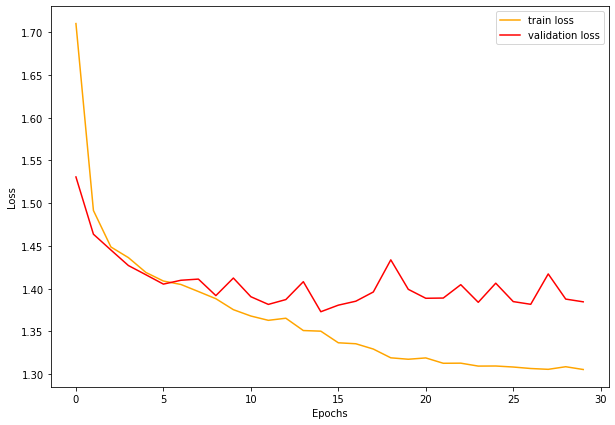

In [32]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss_1, color='orange', label='train loss')
plt.plot(valid_loss_1, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

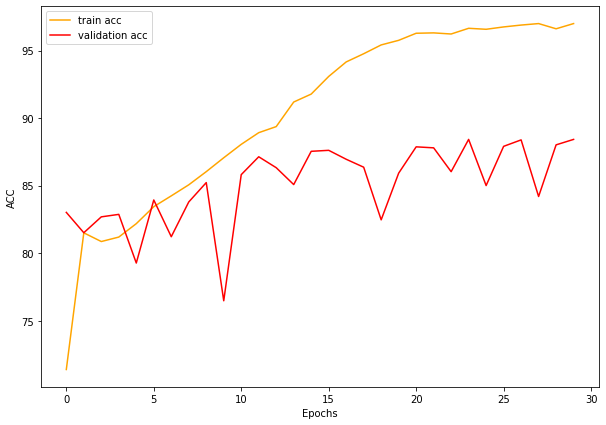

In [33]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_acc_1, color='orange', label='train acc')
plt.plot(valid_acc_1, color='red', label='validation acc')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
plt.show()

### _Model 1 with Augments and Clahe_

In [34]:
anomalies_to_include_1_aug = [0, 1, 2, 3, 4, 5, 6, 7]
augments_to_include_1_aug = [1, 1, 1, 1]

num_classes_1_aug = len(anomalies_to_include_1_aug)

model_1_aug = ResidualNet('ImageNet', 5, num_classes_1_aug, 'CBAM')
model_1_aug.to(device) # sends model to GPU
optimizer = optim.Adam(model_1_aug.parameters(), lr=0.00003)

train_dataset_1_aug = TeethDataLoader(train_clahe_path_to_df, anomalies_to_include_1_aug, True, augments_to_include_1_aug)
valid_dataset_1_aug = TeethDataLoader(valid_clahe_path_to_df, anomalies_to_include_1_aug, False, augments_to_include_1_aug)

# generate shuffled sequence of numbers based on how many images, split train/test
train_idx_1_aug = np.array(range(len(train_dataset_1_aug.labels)))
shuffle(train_idx_1_aug)
valid_idx_1_aug = np.array(range(len(valid_dataset_1_aug.labels)))
shuffle(valid_idx_1_aug)

# Samples elements randomly from a given list of indices, without replacement
train_sampler_1_aug = torch.utils.data.SubsetRandomSampler(train_idx_1_aug)
valid_sampler_1_aug = torch.utils.data.SubsetRandomSampler(valid_idx_1_aug)

# loads images associated with ids/samples from above
train_loader_1_aug = torch.utils.data.DataLoader(train_dataset_1_aug, batch_size=batch_size, sampler=train_sampler_1_aug)
valid_loader_1_aug = torch.utils.data.DataLoader(valid_dataset_1_aug, batch_size=batch_size, sampler=valid_sampler_1_aug)

C:\Users\dental-1\AppData\Local\Temp/ipykernel_18448/1289602504.py:123: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.fc.weight)
C:\Users\dental-1\AppData\Local\Temp/ipykernel_18448/1289602504.py:127: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


In [35]:
train_loss_1_aug = []
valid_loss_1_aug = []
train_acc_1_aug = []
valid_acc_1_aug = []

for epoch in range(1, epochs+1):
    train_epoch_loss, train_epoch_accuracy = train(train_loader_1_aug, model_1_aug, num_classes_1_aug, optimizer, epoch)
    valid_epoch_loss, val_epoch_accuracy = valid(valid_loader_1_aug, model_1_aug, num_classes_1_aug, epoch)
    
    train_loss_1_aug.append(train_epoch_loss)
    valid_loss_1_aug.append(valid_epoch_loss)
    
    train_acc_1_aug.append(train_epoch_accuracy)
    valid_acc_1_aug.append(val_epoch_accuracy)

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [01:12<00:00,  3.66it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 1, loss = 1.7413, batch_idx= 266
Epoch: 1 Accuracy of the Train Images: 59.844742
Confusion Matrix
 [[1.970e+02 8.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.098e+03]
 [2.390e+02 1.877e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.700e+01
  7.370e+02]
 [4.800e+01 2.520e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.190e+02]
 [4.500e+01 7.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  7.100e+01]
 [9.100e+01 2.930e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.500e+01
  3.330e+02]
 [1.070e+02 3.070e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.900e+01
  4.010e+02]
 [1.930e+02 5.370e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 8.300e+01
  6.990e+02]
 [7.600e+02 2.510e+02 0.000e+00 1.000e+00 0.000e+00 0.000e+00 2.000e+00
  8.019e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.12      0.14      0.13      1377
         1.0       0.51      0.65      0.57      2870
         2.0       0.00    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  7.17it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 1 Accuracy of the Valid Images: 82.904412
Confusion Matrix
 [[0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.400e+02]
 [0.000e+00 1.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.100e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.600e+01]
 [0.000e+00 1.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  2.245e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       344
         1.0       0.37      0.20      0.26        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:54<00:00,  4.92it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 2, loss = 1.5823, batch_idx= 266
Epoch: 2 Accuracy of the Train Images: 68.830863
Confusion Matrix
 [[2.000e+00 4.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.332e+03]
 [0.000e+00 2.218e+03 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.270e+02
  5.240e+02]
 [0.000e+00 2.550e+02 6.000e+00 0.000e+00 0.000e+00 1.000e+00 3.400e+01
  1.240e+02]
 [0.000e+00 6.300e+01 0.000e+00 0.000e+00 0.000e+00 3.000e+00 5.400e+01
  7.600e+01]
 [2.000e+00 2.070e+02 0.000e+00 0.000e+00 0.000e+00 1.000e+00 2.350e+02
  2.970e+02]
 [5.000e+00 2.060e+02 0.000e+00 0.000e+00 0.000e+00 1.700e+01 2.810e+02
  3.450e+02]
 [1.000e+00 3.480e+02 1.000e+00 0.000e+00 1.000e+00 4.000e+00 5.890e+02
  5.680e+02]
 [6.000e+00 1.440e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.100e+01
  8.872e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.12      0.00      0.00      1377
         1.0       0.64      0.77      0.70      2870
         2.0       0.86    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.11it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 2 Accuracy of the Valid Images: 83.345588
Confusion Matrix
 [[0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.400e+02]
 [0.000e+00 2.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.600e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.600e+01]
 [0.000e+00 1.500e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.242e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       344
         1.0       0.53      0.49      0.51        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:53<00:00,  4.93it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 3, loss = 1.5312, batch_idx= 266
Epoch: 3 Accuracy of the Train Images: 72.024230
Confusion Matrix
 [[4.000e+00 2.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  1.345e+03]
 [0.000e+00 2.460e+03 3.000e+00 0.000e+00 0.000e+00 2.000e+00 1.280e+02
  2.770e+02]
 [0.000e+00 1.980e+02 5.000e+01 0.000e+00 1.000e+00 8.000e+00 4.500e+01
  1.180e+02]
 [0.000e+00 4.600e+01 0.000e+00 0.000e+00 1.000e+00 9.000e+00 7.000e+01
  7.000e+01]
 [2.000e+00 9.100e+01 2.000e+00 0.000e+00 2.000e+00 2.500e+01 3.490e+02
  2.710e+02]
 [4.000e+00 8.500e+01 0.000e+00 0.000e+00 0.000e+00 6.900e+01 3.740e+02
  3.220e+02]
 [4.000e+00 1.850e+02 3.000e+00 0.000e+00 2.000e+00 2.100e+01 7.550e+02
  5.420e+02]
 [4.000e+00 1.090e+02 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.200e+01
  8.907e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.22      0.00      0.01      1377
         1.0       0.77      0.86      0.81      2870
         2.0       0.86    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.06it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 3 Accuracy of the Valid Images: 83.419118
Confusion Matrix
 [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.440e+02]
 [0.000e+00 1.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.700e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.255e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       344
         1.0       0.88      0.27      0.42        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:53<00:00,  4.94it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 4, loss = 1.5013, batch_idx= 266
Epoch: 4 Accuracy of the Train Images: 73.770877
Confusion Matrix
 [[7.000e+00 1.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.349e+03]
 [0.000e+00 2.586e+03 4.000e+00 0.000e+00 0.000e+00 2.000e+00 9.400e+01
  1.840e+02]
 [1.000e+00 1.470e+02 1.180e+02 0.000e+00 6.000e+00 1.200e+01 3.200e+01
  1.040e+02]
 [0.000e+00 3.900e+01 0.000e+00 0.000e+00 2.000e+00 1.900e+01 7.000e+01
  6.600e+01]
 [4.000e+00 5.800e+01 0.000e+00 0.000e+00 1.900e+01 3.200e+01 3.610e+02
  2.680e+02]
 [3.000e+00 4.600e+01 0.000e+00 0.000e+00 7.000e+00 8.700e+01 4.020e+02
  3.090e+02]
 [2.000e+00 1.220e+02 4.000e+00 0.000e+00 1.100e+01 3.700e+01 8.120e+02
  5.240e+02]
 [3.000e+00 8.500e+01 2.000e+00 0.000e+00 0.000e+00 1.000e+00 2.700e+01
  8.915e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.35      0.01      0.01      1377
         1.0       0.83      0.90      0.87      2870
         2.0       0.92    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.13it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 4 Accuracy of the Valid Images: 83.860294
Confusion Matrix
 [[2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  3.400e+02]
 [0.000e+00 3.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [0.000e+00 0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.500e+01]
 [0.000e+00 1.400e+01 5.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+00
  2.235e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.01      0.01       344
         1.0       0.72      0.76      0.74        51
         2.0       0.40      0.50      0.44         8
         3.0

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:54<00:00,  4.93it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 5, loss = 1.4788, batch_idx= 266
Epoch: 5 Accuracy of the Train Images: 75.499882
Confusion Matrix
 [[3.700e+01 1.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  1.323e+03]
 [3.000e+00 2.668e+03 7.000e+00 0.000e+00 1.000e+00 0.000e+00 8.000e+01
  1.110e+02]
 [2.000e+00 1.240e+02 1.770e+02 0.000e+00 9.000e+00 9.000e+00 2.300e+01
  7.600e+01]
 [0.000e+00 2.900e+01 0.000e+00 0.000e+00 2.000e+00 1.700e+01 8.400e+01
  6.400e+01]
 [1.000e+00 3.900e+01 0.000e+00 0.000e+00 4.000e+01 2.800e+01 3.800e+02
  2.540e+02]
 [2.000e+00 3.700e+01 1.000e+00 0.000e+00 4.000e+00 1.120e+02 4.140e+02
  2.840e+02]
 [4.000e+00 1.000e+02 5.000e+00 0.000e+00 2.000e+01 3.100e+01 8.720e+02
  4.800e+02]
 [1.400e+01 5.700e+01 9.000e+00 0.000e+00 0.000e+00 1.000e+00 2.000e+01
  8.932e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.59      0.03      0.05      1377
         1.0       0.87      0.93      0.90      2870
         2.0       0.89    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  7.19it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 5 Accuracy of the Valid Images: 84.264706
Confusion Matrix
 [[3.200e+01 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  3.080e+02]
 [1.000e+00 4.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00]
 [0.000e+00 0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.400e+01]
 [1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  2.300e+01]
 [1.000e+01 1.600e+01 5.000e+00 0.000e+00 0.000e+00 1.000e+00 1.700e+01
  2.209e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.73      0.09      0.16       344
         1.0       0.73      0.88      0.80        51
         2.0       0.36      0.50      0.42         8
         3.0

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:53<00:00,  4.93it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 6, loss = 1.4598, batch_idx= 266
Epoch: 6 Accuracy of the Train Images: 76.723124
Confusion Matrix
 [[4.900e+01 9.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+00
  1.315e+03]
 [2.000e+00 2.704e+03 1.000e+00 0.000e+00 2.000e+00 2.000e+00 8.300e+01
  7.600e+01]
 [0.000e+00 8.500e+01 2.410e+02 0.000e+00 8.000e+00 1.000e+00 2.600e+01
  5.900e+01]
 [0.000e+00 2.900e+01 0.000e+00 0.000e+00 7.000e+00 2.300e+01 7.700e+01
  6.000e+01]
 [1.000e+00 3.300e+01 0.000e+00 0.000e+00 6.600e+01 2.300e+01 3.970e+02
  2.220e+02]
 [2.000e+00 2.500e+01 0.000e+00 0.000e+00 1.400e+01 1.240e+02 4.450e+02
  2.440e+02]
 [2.000e+00 8.600e+01 5.000e+00 0.000e+00 2.900e+01 2.800e+01 9.420e+02
  4.200e+02]
 [1.900e+01 5.100e+01 4.000e+00 0.000e+00 1.000e+00 5.000e+00 3.300e+01
  8.920e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.65      0.04      0.07      1377
         1.0       0.89      0.94      0.92      2870
         2.0       0.96    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  7.24it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 6 Accuracy of the Valid Images: 82.610294
Confusion Matrix
 [[9.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  3.330e+02]
 [0.000e+00 4.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.600e+01]
 [2.000e+00 6.100e+01 1.000e+00 0.000e+00 0.000e+00 1.000e+00 2.000e+00
  2.191e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.82      0.03      0.05       344
         1.0       0.42      0.90      0.58        51
         2.0       0.00      0.00      0.00         8
         3.0

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:53<00:00,  4.94it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 7, loss = 1.4432, batch_idx= 266
Epoch: 7 Accuracy of the Train Images: 78.452129
Confusion Matrix
 [[9.000e+01 9.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  1.275e+03]
 [1.000e+00 2.747e+03 1.000e+00 0.000e+00 3.000e+00 1.000e+00 6.300e+01
  5.400e+01]
 [0.000e+00 4.200e+01 3.090e+02 0.000e+00 5.000e+00 3.000e+00 1.900e+01
  4.200e+01]
 [0.000e+00 3.200e+01 0.000e+00 0.000e+00 1.200e+01 2.400e+01 7.000e+01
  5.800e+01]
 [0.000e+00 1.900e+01 0.000e+00 0.000e+00 1.050e+02 2.500e+01 3.790e+02
  2.140e+02]
 [2.000e+00 2.500e+01 0.000e+00 0.000e+00 1.500e+01 1.460e+02 4.440e+02
  2.220e+02]
 [0.000e+00 7.900e+01 6.000e+00 0.000e+00 3.800e+01 2.400e+01 9.990e+02
  3.660e+02]
 [2.300e+01 3.600e+01 4.000e+00 0.000e+00 1.000e+00 2.000e+00 2.300e+01
  8.944e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.78      0.07      0.12      1377
         1.0       0.92      0.96      0.94      2870
         2.0       0.97    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  7.19it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 7 Accuracy of the Valid Images: 84.227941
Confusion Matrix
 [[1.100e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  3.310e+02]
 [0.000e+00 4.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.000e+00]
 [0.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.600e+01]
 [0.000e+00 1.100e+01 3.000e+00 0.000e+00 0.000e+00 1.000e+00 9.000e+00
  2.234e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.03      0.06       344
         1.0       0.78      0.82      0.80        51
         2.0       0.50      0.38      0.43         8
         3.0

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:53<00:00,  4.93it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 8, loss = 1.4272, batch_idx= 266
Epoch: 8 Accuracy of the Train Images: 79.704775
Confusion Matrix
 [[1.020e+02 7.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  1.263e+03]
 [1.000e+00 2.769e+03 2.000e+00 0.000e+00 4.000e+00 0.000e+00 5.300e+01
  4.100e+01]
 [1.000e+00 2.800e+01 3.380e+02 0.000e+00 7.000e+00 1.000e+00 1.600e+01
  2.900e+01]
 [0.000e+00 2.900e+01 0.000e+00 0.000e+00 1.600e+01 2.200e+01 7.300e+01
  5.600e+01]
 [0.000e+00 1.200e+01 0.000e+00 0.000e+00 1.390e+02 4.300e+01 3.640e+02
  1.840e+02]
 [0.000e+00 1.300e+01 0.000e+00 0.000e+00 1.500e+01 1.940e+02 4.420e+02
  1.900e+02]
 [1.000e+00 6.000e+01 3.000e+00 0.000e+00 4.100e+01 4.300e+01 1.063e+03
  3.010e+02]
 [2.300e+01 3.000e+01 7.000e+00 0.000e+00 1.000e+00 1.000e+00 2.300e+01
  8.948e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.80      0.07      0.14      1377
         1.0       0.94      0.96      0.95      2870
         2.0       0.96    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.14it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 8 Accuracy of the Valid Images: 83.970588
Confusion Matrix
 [[4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.400e+02]
 [0.000e+00 4.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.100e+01]
 [0.000e+00 0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [0.000e+00 1.200e+01 4.000e+00 0.000e+00 0.000e+00 1.000e+00 5.000e+00
  2.236e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.01      0.02       344
         1.0       0.77      0.78      0.78        51
         2.0       0.50      0.50      0.50         8
         3.0

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:54<00:00,  4.90it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 9, loss = 1.4122, batch_idx= 266
Epoch: 9 Accuracy of the Train Images: 80.992708
Confusion Matrix
 [[1.330e+02 7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.236e+03]
 [0.000e+00 2.784e+03 1.000e+00 0.000e+00 2.000e+00 1.000e+00 5.000e+01
  3.200e+01]
 [0.000e+00 1.200e+01 3.600e+02 0.000e+00 6.000e+00 0.000e+00 1.600e+01
  2.600e+01]
 [0.000e+00 3.300e+01 0.000e+00 0.000e+00 2.000e+01 1.800e+01 6.400e+01
  6.100e+01]
 [0.000e+00 8.000e+00 0.000e+00 0.000e+00 1.900e+02 4.200e+01 3.310e+02
  1.710e+02]
 [0.000e+00 1.100e+01 1.000e+00 0.000e+00 1.500e+01 2.370e+02 4.410e+02
  1.490e+02]
 [1.000e+00 5.200e+01 4.000e+00 0.000e+00 4.600e+01 3.300e+01 1.112e+03
  2.640e+02]
 [3.000e+01 2.200e+01 3.000e+00 0.000e+00 1.000e+00 4.000e+00 1.700e+01
  8.956e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.81      0.10      0.17      1377
         1.0       0.95      0.97      0.96      2870
         2.0       0.98    

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.11it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 9 Accuracy of the Valid Images: 84.154412
Confusion Matrix
 [[1.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.310e+02]
 [0.000e+00 4.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+01]
 [0.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  2.600e+01]
 [0.000e+00 1.200e+01 4.000e+00 0.000e+00 0.000e+00 2.000e+00 8.000e+00
  2.232e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.04      0.07       344
         1.0       0.77      0.80      0.79        51
         2.0       0.43      0.38      0.40         8
         3.0

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:53<00:00,  4.94it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 10, loss = 1.3970, batch_idx= 266
Epoch: 10 Accuracy of the Train Images: 82.321807
Confusion Matrix
 [[1.320e+02 7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  1.235e+03]
 [0.000e+00 2.798e+03 2.000e+00 0.000e+00 4.000e+00 0.000e+00 4.000e+01
  2.600e+01]
 [0.000e+00 6.000e+00 3.760e+02 0.000e+00 5.000e+00 0.000e+00 1.300e+01
  2.000e+01]
 [0.000e+00 3.100e+01 1.000e+00 0.000e+00 2.000e+01 2.400e+01 6.300e+01
  5.700e+01]
 [0.000e+00 4.000e+00 0.000e+00 0.000e+00 2.460e+02 4.600e+01 2.950e+02
  1.510e+02]
 [0.000e+00 1.400e+01 0.000e+00 0.000e+00 1.800e+01 3.190e+02 3.940e+02
  1.090e+02]
 [0.000e+00 5.000e+01 2.000e+00 0.000e+00 5.300e+01 4.300e+01 1.148e+03
  2.160e+02]
 [1.600e+01 1.900e+01 2.000e+00 0.000e+00 1.000e+00 2.000e+00 1.400e+01
  8.979e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.89      0.10      0.17      1377
         1.0       0.96      0.97      0.96      2870
         2.0       0.98  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.00it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 10 Accuracy of the Valid Images: 85.257353
Confusion Matrix
 [[6.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.810e+02]
 [0.000e+00 4.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.400e+01]
 [1.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  2.400e+01]
 [1.800e+01 1.700e+01 4.000e+00 0.000e+00 0.000e+00 6.000e+00 7.000e+00
  2.206e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.77      0.18      0.29       344
         1.0       0.72      0.92      0.81        51
         2.0       0.50      0.50      0.50         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:53<00:00,  4.93it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 11, loss = 1.3832, batch_idx= 266
Epoch: 11 Accuracy of the Train Images: 83.756763
Confusion Matrix
 [[1.470e+02 5.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 2.000e+00
  1.222e+03]
 [0.000e+00 2.805e+03 0.000e+00 0.000e+00 4.000e+00 1.000e+00 3.900e+01
  2.100e+01]
 [1.000e+00 1.000e+00 3.910e+02 0.000e+00 3.000e+00 0.000e+00 1.400e+01
  1.000e+01]
 [0.000e+00 3.200e+01 0.000e+00 0.000e+00 2.700e+01 1.800e+01 5.900e+01
  6.000e+01]
 [0.000e+00 0.000e+00 1.000e+00 0.000e+00 3.160e+02 4.100e+01 2.610e+02
  1.230e+02]
 [0.000e+00 1.100e+01 1.000e+00 0.000e+00 1.500e+01 3.880e+02 3.520e+02
  8.700e+01]
 [0.000e+00 3.600e+01 0.000e+00 0.000e+00 5.300e+01 4.500e+01 1.203e+03
  1.750e+02]
 [1.500e+01 1.500e+01 2.000e+00 0.000e+00 2.000e+00 2.000e+00 5.000e+00
  8.992e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.90      0.11      0.19      1377
         1.0       0.97      0.98      0.97      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.15it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 11 Accuracy of the Valid Images: 83.713235
Confusion Matrix
 [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  3.430e+02]
 [0.000e+00 4.100e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+01]
 [0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.400e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.600e+01]
 [0.000e+00 1.400e+01 2.000e+00 0.000e+00 0.000e+00 2.000e+00 6.000e+00
  2.234e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       344
         1.0       0.73      0.80      0.77        51
         2.0       0.50      0.25      0.33         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:54<00:00,  4.92it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 12, loss = 1.3714, batch_idx= 266
Epoch: 12 Accuracy of the Train Images: 84.850623
Confusion Matrix
 [[1.160e+02 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.255e+03]
 [0.000e+00 2.821e+03 0.000e+00 0.000e+00 0.000e+00 1.000e+00 2.700e+01
  2.100e+01]
 [0.000e+00 2.000e+00 3.920e+02 0.000e+00 7.000e+00 0.000e+00 9.000e+00
  1.000e+01]
 [0.000e+00 3.000e+01 0.000e+00 0.000e+00 2.700e+01 2.300e+01 5.300e+01
  6.300e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 3.900e+02 3.400e+01 2.080e+02
  1.090e+02]
 [0.000e+00 1.300e+01 0.000e+00 0.000e+00 1.700e+01 4.740e+02 2.790e+02
  7.100e+01]
 [0.000e+00 3.000e+01 1.000e+00 0.000e+00 5.300e+01 5.200e+01 1.244e+03
  1.320e+02]
 [1.900e+01 8.000e+00 2.000e+00 0.000e+00 1.000e+00 5.000e+00 7.000e+00
  8.991e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.86      0.08      0.15      1377
         1.0       0.97      0.98      0.98      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.06it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 12 Accuracy of the Valid Images: 83.308824
Confusion Matrix
 [[1.050e+02 0.000e+00 0.000e+00 0.000e+00 3.000e+00 1.000e+00 0.000e+00
  2.350e+02]
 [0.000e+00 4.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [1.000e+00 0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 2.000e+00
  1.200e+01]
 [2.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
  2.300e+01]
 [4.900e+01 1.700e+01 4.000e+00 0.000e+00 2.700e+01 2.300e+01 2.600e+01
  2.112e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.67      0.31      0.42       344
         1.0       0.73      0.88      0.80        51
         2.0       0.50      0.50      0.50         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:54<00:00,  4.91it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 13, loss = 1.3607, batch_idx= 266
Epoch: 13 Accuracy of the Train Images: 86.303223
Confusion Matrix
 [[1.090e+02 4.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.261e+03]
 [0.000e+00 2.827e+03 0.000e+00 0.000e+00 2.000e+00 0.000e+00 2.100e+01
  2.000e+01]
 [0.000e+00 0.000e+00 3.980e+02 0.000e+00 7.000e+00 0.000e+00 6.000e+00
  9.000e+00]
 [0.000e+00 3.200e+01 0.000e+00 0.000e+00 3.300e+01 2.100e+01 4.500e+01
  6.500e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 4.710e+02 2.600e+01 1.520e+02
  9.100e+01]
 [0.000e+00 7.000e+00 0.000e+00 0.000e+00 1.300e+01 5.800e+02 2.060e+02
  4.800e+01]
 [0.000e+00 2.000e+01 0.000e+00 0.000e+00 5.800e+01 4.300e+01 1.284e+03
  1.070e+02]
 [1.200e+01 8.000e+00 2.000e+00 0.000e+00 1.000e+00 0.000e+00 4.000e+00
  9.006e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.90      0.08      0.15      1377
         1.0       0.97      0.99      0.98      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  7.21it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 13 Accuracy of the Valid Images: 84.264706
Confusion Matrix
 [[1.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.320e+02]
 [0.000e+00 3.800e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [0.000e+00 6.000e+00 4.000e+00 0.000e+00 1.000e+00 3.000e+00 6.000e+00
  2.238e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.03      0.07       344
         1.0       0.86      0.75      0.80        51
         2.0       0.50      0.50      0.50         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:53<00:00,  4.93it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 14, loss = 1.3518, batch_idx= 266
Epoch: 14 Accuracy of the Train Images: 87.367678
Confusion Matrix
 [[1.030e+02 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.272e+03]
 [0.000e+00 2.828e+03 0.000e+00 0.000e+00 0.000e+00 2.000e+00 1.800e+01
  2.200e+01]
 [0.000e+00 1.000e+00 4.030e+02 0.000e+00 6.000e+00 0.000e+00 5.000e+00
  5.000e+00]
 [1.000e+00 2.800e+01 0.000e+00 0.000e+00 4.400e+01 2.000e+01 4.600e+01
  5.700e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 5.320e+02 2.100e+01 1.140e+02
  7.400e+01]
 [0.000e+00 8.000e+00 0.000e+00 0.000e+00 8.000e+00 6.520e+02 1.430e+02
  4.300e+01]
 [0.000e+00 1.000e+01 2.000e+00 0.000e+00 4.700e+01 4.400e+01 1.333e+03
  7.600e+01]
 [1.400e+01 9.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 5.000e+00
  9.005e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.87      0.07      0.14      1377
         1.0       0.98      0.99      0.98      2870
         2.0       1.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:05<00:00,  7.26it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 14 Accuracy of the Valid Images: 81.139706
Confusion Matrix
 [[4.000e+00 2.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
  3.360e+02]
 [0.000e+00 3.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.900e+01]
 [0.000e+00 0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
  2.500e+01]
 [2.000e+00 9.000e+00 5.000e+00 0.000e+00 1.100e+01 3.100e+01 3.300e+01
  2.167e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.67      0.01      0.02       344
         1.0       0.74      0.63      0.68        51
         2.0       0.44      0.50      0.47         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:54<00:00,  4.92it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 15, loss = 1.3415, batch_idx= 266
Epoch: 15 Accuracy of the Train Images: 88.285109
Confusion Matrix
 [[1.080e+02 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.265e+03]
 [0.000e+00 2.840e+03 0.000e+00 0.000e+00 1.000e+00 1.000e+00 1.300e+01
  1.500e+01]
 [0.000e+00 0.000e+00 4.040e+02 0.000e+00 6.000e+00 0.000e+00 2.000e+00
  8.000e+00]
 [1.000e+00 2.900e+01 0.000e+00 0.000e+00 3.200e+01 2.200e+01 5.000e+01
  6.200e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 5.780e+02 1.700e+01 8.600e+01
  5.900e+01]
 [0.000e+00 6.000e+00 0.000e+00 0.000e+00 3.000e+00 7.000e+02 1.170e+02
  2.800e+01]
 [0.000e+00 8.000e+00 0.000e+00 0.000e+00 3.100e+01 3.500e+01 1.372e+03
  6.600e+01]
 [1.000e+01 6.000e+00 2.000e+00 0.000e+00 0.000e+00 2.000e+00 3.000e+00
  9.010e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.91      0.08      0.14      1377
         1.0       0.98      0.99      0.99      2870
         2.0       1.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.14it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 15 Accuracy of the Valid Images: 83.933824
Confusion Matrix
 [[1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.430e+02]
 [0.000e+00 3.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.900e+01]
 [0.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
  2.500e+01]
 [0.000e+00 3.000e+00 3.000e+00 0.000e+00 0.000e+00 3.000e+00 2.000e+00
  2.247e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.00      0.01       344
         1.0       0.91      0.63      0.74        51
         2.0       0.50      0.38      0.43         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:54<00:00,  4.92it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 16, loss = 1.3347, batch_idx= 266
Epoch: 16 Accuracy of the Train Images: 88.914373
Confusion Matrix
 [[9.800e+01 2.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
  1.275e+03]
 [0.000e+00 2.842e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.100e+01
  1.700e+01]
 [0.000e+00 1.000e+00 4.070e+02 0.000e+00 6.000e+00 0.000e+00 2.000e+00
  4.000e+00]
 [0.000e+00 2.900e+01 2.000e+00 0.000e+00 3.300e+01 2.500e+01 4.500e+01
  6.200e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 6.110e+02 1.600e+01 7.200e+01
  4.200e+01]
 [0.000e+00 8.000e+00 0.000e+00 0.000e+00 6.000e+00 7.430e+02 7.100e+01
  2.600e+01]
 [0.000e+00 4.000e+00 0.000e+00 0.000e+00 2.600e+01 2.800e+01 1.405e+03
  4.900e+01]
 [9.000e+00 5.000e+00 2.000e+00 0.000e+00 0.000e+00 1.000e+00 3.000e+00
  9.013e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.92      0.07      0.13      1377
         1.0       0.98      0.99      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.06it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 16 Accuracy of the Valid Images: 83.676471
Confusion Matrix
 [[4.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.390e+02]
 [0.000e+00 4.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00]
 [0.000e+00 1.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.300e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.500e+01]
 [0.000e+00 2.200e+01 4.000e+00 0.000e+00 0.000e+00 2.000e+00 8.000e+00
  2.222e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.01      0.02       344
         1.0       0.65      0.90      0.75        51
         2.0       0.43      0.38      0.40         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:54<00:00,  4.90it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 17, loss = 1.3290, batch_idx= 266
Epoch: 17 Accuracy of the Train Images: 89.649494
Confusion Matrix
 [[1.120e+02 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.262e+03]
 [0.000e+00 2.844e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+01
  1.600e+01]
 [1.000e+00 0.000e+00 4.070e+02 0.000e+00 6.000e+00 0.000e+00 1.000e+00
  5.000e+00]
 [1.000e+00 3.700e+01 2.000e+00 0.000e+00 3.100e+01 1.900e+01 4.500e+01
  6.100e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 6.590e+02 3.000e+00 4.300e+01
  3.600e+01]
 [0.000e+00 5.000e+00 0.000e+00 0.000e+00 3.000e+00 7.670e+02 5.800e+01
  2.100e+01]
 [0.000e+00 4.000e+00 0.000e+00 0.000e+00 1.500e+01 1.600e+01 1.438e+03
  3.900e+01]
 [6.000e+00 5.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 2.000e+00
  9.017e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.93      0.08      0.15      1377
         1.0       0.98      0.99      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.11it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 17 Accuracy of the Valid Images: 83.713235
Confusion Matrix
 [[2.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.170e+02]
 [0.000e+00 4.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.100e+01]
 [0.000e+00 0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.600e+01]
 [4.000e+00 1.500e+01 4.000e+00 0.000e+00 5.000e+00 1.000e+01 1.500e+01
  2.205e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.87      0.08      0.14       344
         1.0       0.73      0.78      0.75        51
         2.0       0.50      0.50      0.50         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:54<00:00,  4.88it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 18, loss = 1.3226, batch_idx= 266
Epoch: 18 Accuracy of the Train Images: 89.884733
Confusion Matrix
 [[7.900e+01 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.296e+03]
 [0.000e+00 2.851e+03 0.000e+00 0.000e+00 0.000e+00 1.000e+00 6.000e+00
  1.200e+01]
 [0.000e+00 0.000e+00 4.110e+02 0.000e+00 4.000e+00 0.000e+00 1.000e+00
  4.000e+00]
 [0.000e+00 3.200e+01 2.000e+00 0.000e+00 3.300e+01 1.800e+01 4.800e+01
  6.300e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 6.850e+02 2.000e+00 2.900e+01
  2.400e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 7.850e+02 5.600e+01
  1.100e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 1.100e+01 1.800e+01 1.452e+03
  2.900e+01]
 [5.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  9.021e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.94      0.06      0.11      1377
         1.0       0.99      0.99      0.99      2870
         2.0       1.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.93it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 18 Accuracy of the Valid Images: 83.823529
Confusion Matrix
 [[1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.430e+02]
 [0.000e+00 3.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.600e+01]
 [0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  7.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [0.000e+00 1.000e+01 1.000e+00 0.000e+00 0.000e+00 2.000e+00 2.000e+00
  2.243e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.00      0.01       344
         1.0       0.78      0.69      0.73        51
         2.0       0.50      0.12      0.20         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:54<00:00,  4.90it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 19, loss = 1.3192, batch_idx= 266
Epoch: 19 Accuracy of the Train Images: 90.296401
Confusion Matrix
 [[9.800e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
  1.276e+03]
 [0.000e+00 2.854e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+00
  1.200e+01]
 [0.000e+00 0.000e+00 4.120e+02 0.000e+00 4.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 3.300e+01 0.000e+00 0.000e+00 3.400e+01 2.200e+01 4.700e+01
  6.000e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.040e+02 0.000e+00 1.900e+01
  1.900e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 8.070e+02 3.200e+01
  1.300e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 1.000e+01 1.300e+01 1.461e+03
  2.600e+01]
 [6.000e+00 6.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
  9.018e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.94      0.07      0.13      1377
         1.0       0.99      0.99      0.99      2870
         2.0       1.00  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.03it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 19 Accuracy of the Valid Images: 81.617647
Confusion Matrix
 [[2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  3.410e+02]
 [0.000e+00 3.500e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.600e+01]
 [0.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 1.000e+00
  2.400e+01]
 [0.000e+00 1.300e+01 3.000e+00 0.000e+00 6.000e+00 1.900e+01 3.800e+01
  2.179e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       1.00      0.01      0.01       344
         1.0       0.73      0.69      0.71        51
         2.0       0.50      0.38      0.43         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:55<00:00,  4.83it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 20, loss = 1.3158, batch_idx= 266
Epoch: 20 Accuracy of the Train Images: 90.613973
Confusion Matrix
 [[1.060e+02 2.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  1.268e+03]
 [0.000e+00 2.856e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  1.100e+01]
 [0.000e+00 0.000e+00 4.110e+02 0.000e+00 4.000e+00 0.000e+00 0.000e+00
  5.000e+00]
 [0.000e+00 3.200e+01 4.000e+00 0.000e+00 3.800e+01 1.900e+01 4.600e+01
  5.700e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 7.110e+02 0.000e+00 1.100e+01
  1.800e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 8.250e+02 2.300e+01
  4.000e+00]
 [0.000e+00 5.000e+00 0.000e+00 0.000e+00 5.000e+00 1.100e+01 1.476e+03
  1.500e+01]
 [4.000e+00 5.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  9.023e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.96      0.08      0.14      1377
         1.0       0.98      1.00      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.13it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 20 Accuracy of the Valid Images: 83.088235
Confusion Matrix
 [[2.200e+01 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
  3.200e+02]
 [0.000e+00 4.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00 1.000e+00
  1.200e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
  2.400e+01]
 [2.000e+00 1.700e+01 5.000e+00 0.000e+00 1.000e+01 1.100e+01 2.400e+01
  2.189e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.92      0.06      0.12       344
         1.0       0.70      0.84      0.77        51
         2.0       0.44      0.50      0.47         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:55<00:00,  4.81it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 21, loss = 1.3124, batch_idx= 266
Epoch: 21 Accuracy of the Train Images: 90.825688
Confusion Matrix
 [[1.070e+02 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.266e+03]
 [0.000e+00 2.856e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  1.100e+01]
 [0.000e+00 0.000e+00 4.150e+02 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 3.100e+01 4.000e+00 0.000e+00 3.500e+01 2.500e+01 3.400e+01
  6.700e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.250e+02 0.000e+00 5.000e+00
  1.200e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 8.270e+02 1.800e+01
  8.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 7.000e+00 1.491e+03
  1.100e+01]
 [2.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+00
  9.023e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.98      0.08      0.14      1377
         1.0       0.99      1.00      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.09it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 21 Accuracy of the Valid Images: 76.213235
Confusion Matrix
 [[9.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+01 7.000e+00
  3.180e+02]
 [0.000e+00 4.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  8.000e+00]
 [0.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 2.000e+00
  1.000e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 4.000e+00
  2.200e+01]
 [1.000e+00 1.700e+01 4.000e+00 0.000e+00 3.000e+00 9.100e+01 1.300e+02
  2.012e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.90      0.03      0.05       344
         1.0       0.71      0.82      0.76        51
         2.0       0.43      0.38      0.40         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:54<00:00,  4.91it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 22, loss = 1.3110, batch_idx= 266
Epoch: 22 Accuracy of the Train Images: 90.937426
Confusion Matrix
 [[1.180e+02 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.256e+03]
 [0.000e+00 2.857e+03 0.000e+00 0.000e+00 0.000e+00 2.000e+00 2.000e+00
  9.000e+00]
 [0.000e+00 0.000e+00 4.150e+02 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 3.000e+01 4.000e+00 0.000e+00 3.500e+01 1.900e+01 5.400e+01
  5.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.240e+02 0.000e+00 8.000e+00
  1.000e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 8.300e+02 1.900e+01
  3.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 2.000e+00 4.000e+00 1.495e+03
  1.000e+01]
 [3.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  9.024e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.98      0.09      0.16      1377
         1.0       0.99      1.00      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.03it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 22 Accuracy of the Valid Images: 83.051471
Confusion Matrix
 [[7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.370e+02]
 [0.000e+00 3.600e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
  2.500e+01]
 [1.000e+00 1.000e+01 4.000e+00 0.000e+00 0.000e+00 1.000e+01 2.200e+01
  2.211e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.88      0.02      0.04       344
         1.0       0.78      0.71      0.74        51
         2.0       0.50      0.50      0.50         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:55<00:00,  4.83it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 23, loss = 1.3101, batch_idx= 266
Epoch: 23 Accuracy of the Train Images: 90.984474
Confusion Matrix
 [[1.200e+02 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.255e+03]
 [0.000e+00 2.861e+03 0.000e+00 0.000e+00 1.000e+00 0.000e+00 2.000e+00
  6.000e+00]
 [0.000e+00 0.000e+00 4.130e+02 0.000e+00 2.000e+00 0.000e+00 1.000e+00
  4.000e+00]
 [0.000e+00 3.600e+01 3.000e+00 0.000e+00 2.300e+01 3.100e+01 4.600e+01
  5.700e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.260e+02 1.000e+00 4.000e+00
  1.100e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 8.310e+02 1.600e+01
  6.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 5.000e+00 1.497e+03
  9.000e+00]
 [3.000e+00 3.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 2.000e+00
  9.023e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.98      0.09      0.16      1377
         1.0       0.99      1.00      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.69it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 23 Accuracy of the Valid Images: 83.713235
Confusion Matrix
 [[1.600e+01 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.240e+02]
 [0.000e+00 4.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 1.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  5.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.300e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.500e+01]
 [2.000e+00 3.400e+01 3.000e+00 0.000e+00 0.000e+00 3.000e+00 4.000e+00
  2.212e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.89      0.05      0.09       344
         1.0       0.53      0.92      0.68        51
         2.0       0.40      0.25      0.31         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:55<00:00,  4.76it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 24, loss = 1.3075, batch_idx= 266
Epoch: 24 Accuracy of the Train Images: 91.155022
Confusion Matrix
 [[1.200e+02 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.254e+03]
 [0.000e+00 2.861e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  7.000e+00]
 [0.000e+00 0.000e+00 4.150e+02 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  4.000e+00]
 [0.000e+00 3.100e+01 4.000e+00 0.000e+00 3.400e+01 2.500e+01 4.300e+01
  5.900e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.280e+02 0.000e+00 3.000e+00
  1.100e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 8.470e+02 4.000e+00
  2.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.505e+03
  6.000e+00]
 [2.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00
  9.024e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.98      0.09      0.16      1377
         1.0       0.99      1.00      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.78it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 24 Accuracy of the Valid Images: 83.566176
Confusion Matrix
 [[1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.430e+02]
 [0.000e+00 3.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.900e+01]
 [0.000e+00 0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [1.000e+00 5.000e+00 5.000e+00 0.000e+00 0.000e+00 7.000e+00 5.000e+00
  2.235e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.50      0.00      0.01       344
         1.0       0.86      0.63      0.73        51
         2.0       0.44      0.50      0.47         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:55<00:00,  4.76it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 25, loss = 1.3054, batch_idx= 266
Epoch: 25 Accuracy of the Train Images: 91.202070
Confusion Matrix
 [[1.170e+02 2.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 0.000e+00
  1.255e+03]
 [0.000e+00 2.864e+03 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 4.150e+02 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [1.000e+00 2.900e+01 3.000e+00 0.000e+00 4.400e+01 2.700e+01 3.700e+01
  5.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.320e+02 0.000e+00 1.000e+00
  9.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 8.460e+02 4.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.507e+03
  4.000e+00]
 [2.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  9.027e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.97      0.08      0.16      1377
         1.0       0.99      1.00      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.87it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 25 Accuracy of the Valid Images: 83.786765
Confusion Matrix
 [[2.10e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 3.22e+02]
 [0.00e+00 4.40e+01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 7.00e+00]
 [0.00e+00 1.00e+00 3.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 4.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 1.30e+01]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 1.00e+00 1.00e+00 1.20e+01]
 [0.00e+00 1.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00 2.50e+01]
 [2.00e+00 2.20e+01 3.00e+00 0.00e+00 3.00e+00 9.00e+00 9.00e+00 2.21e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.91      0.06      0.11       344
         1.0       0.65      0.86      0.74        51
         2.0       0.50      0.38      0.43         8
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00    

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:54<00:00,  4.88it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 26, loss = 1.3055, batch_idx= 266
Epoch: 26 Accuracy of the Train Images: 91.278523
Confusion Matrix
 [[1.240e+02 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.249e+03]
 [0.000e+00 2.865e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 4.150e+02 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [1.000e+00 3.700e+01 3.000e+00 0.000e+00 3.200e+01 2.700e+01 4.500e+01
  5.100e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.340e+02 0.000e+00 1.000e+00
  7.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 8.470e+02 1.000e+00
  6.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.506e+03
  4.000e+00]
 [1.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  9.030e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.98      0.09      0.17      1377
         1.0       0.99      1.00      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.97it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 26 Accuracy of the Valid Images: 81.433824
Confusion Matrix
 [[2.800e+01 0.000e+00 2.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  3.130e+02]
 [0.000e+00 4.600e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 6.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.000e+00
  1.300e+01]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 2.000e+00
  2.300e+01]
 [3.000e+00 3.200e+01 1.600e+01 0.000e+00 7.000e+00 1.000e+01 5.800e+01
  2.132e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.90      0.08      0.15       344
         1.0       0.58      0.90      0.71        51
         2.0       0.24      0.75      0.36         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:54<00:00,  4.91it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 27, loss = 1.3062, batch_idx= 266
Epoch: 27 Accuracy of the Train Images: 91.372618
Confusion Matrix
 [[1.490e+02 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.225e+03]
 [0.000e+00 2.863e+03 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
  5.000e+00]
 [0.000e+00 0.000e+00 4.150e+02 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  4.000e+00]
 [1.000e+00 3.300e+01 1.000e+01 0.000e+00 3.200e+01 3.300e+01 3.800e+01
  4.900e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.360e+02 0.000e+00 0.000e+00
  6.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 8.470e+02 3.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.504e+03
  8.000e+00]
 [4.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+00
  9.023e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.97      0.11      0.19      1377
         1.0       0.99      1.00      0.99      2870
         2.0       0.98  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  7.09it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 27 Accuracy of the Valid Images: 84.485294
Confusion Matrix
 [[2.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.200e+02]
 [0.000e+00 3.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [0.000e+00 0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  1.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [3.000e+00 1.100e+01 5.000e+00 0.000e+00 0.000e+00 4.000e+00 4.000e+00
  2.231e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.89      0.07      0.13       344
         1.0       0.78      0.76      0.77        51
         2.0       0.44      0.50      0.47         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:55<00:00,  4.81it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 28, loss = 1.3049, batch_idx= 266
Epoch: 28 Accuracy of the Train Images: 91.643143
Confusion Matrix
 [[1.850e+02 2.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  1.189e+03]
 [0.000e+00 2.868e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.000e+00]
 [0.000e+00 0.000e+00 4.170e+02 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  2.000e+00]
 [1.000e+00 3.500e+01 7.000e+00 0.000e+00 3.400e+01 2.600e+01 3.500e+01
  5.800e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.360e+02 0.000e+00 0.000e+00
  6.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 8.480e+02 3.000e+00
  2.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 4.000e+00 1.502e+03
  4.000e+00]
 [2.000e+00 2.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00
  9.027e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.98      0.13      0.24      1377
         1.0       0.99      1.00      0.99      2870
         2.0       0.98  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.83it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 28 Accuracy of the Valid Images: 84.154412
Confusion Matrix
 [[2.200e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.220e+02]
 [0.000e+00 3.700e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 4.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  4.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [2.000e+00 1.100e+01 4.000e+00 0.000e+00 0.000e+00 5.000e+00 1.000e+01
  2.226e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.92      0.06      0.12       344
         1.0       0.77      0.73      0.75        51
         2.0       0.50      0.50      0.50         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:55<00:00,  4.81it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 29, loss = 1.3042, batch_idx= 266
Epoch: 29 Accuracy of the Train Images: 91.554928
Confusion Matrix
 [[1.710e+02 2.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.202e+03]
 [0.000e+00 2.869e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00]
 [0.000e+00 0.000e+00 4.190e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.000e+00]
 [0.000e+00 3.400e+01 3.000e+00 0.000e+00 3.600e+01 2.800e+01 3.800e+01
  5.700e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.310e+02 0.000e+00 5.000e+00
  6.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 8.450e+02 2.000e+00
  6.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.509e+03
  3.000e+00]
 [4.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
  9.024e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.98      0.12      0.22      1377
         1.0       0.99      1.00      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.87it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Epoch: 29 Accuracy of the Valid Images: 84.154412
Confusion Matrix
 [[2.400e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.200e+02]
 [0.000e+00 3.900e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.200e+01]
 [0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [3.000e+00 2.400e+01 1.000e+00 0.000e+00 0.000e+00 3.000e+00 2.000e+00
  2.225e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.89      0.07      0.13       344
         1.0       0.61      0.76      0.68        51
         2.0       0.50      0.12      0.20         8
         3.

  0%|          | 0/266 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 266/266 [00:55<00:00,  4.78it/s]
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epoch 30, loss = 1.3057, batch_idx= 266
Epoch: 30 Accuracy of the Train Images: 91.690191
Confusion Matrix
 [[2.170e+02 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.157e+03]
 [0.000e+00 2.869e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00]
 [0.000e+00 0.000e+00 4.180e+02 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  1.000e+00]
 [0.000e+00 3.200e+01 5.000e+00 0.000e+00 3.600e+01 2.500e+01 4.000e+01
  5.800e+01]
 [0.000e+00 2.000e+00 0.000e+00 0.000e+00 7.320e+02 0.000e+00 1.000e+00
  7.000e+00]
 [0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 8.400e+02 7.000e+00
  6.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 3.000e+00 1.497e+03
  1.000e+01]
 [5.000e+00 3.000e+00 0.000e+00 0.000e+00 1.000e+00 2.000e+00 4.000e+00
  9.018e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.98      0.16      0.27      1377
         1.0       0.99      1.00      0.99      2870
         2.0       0.99  

  0%|          | 0/43 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 43/43 [00:06<00:00,  6.76it/s]


Epoch: 30 Accuracy of the Valid Images: 84.301471
Confusion Matrix
 [[7.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.370e+02]
 [0.000e+00 4.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.100e+01]
 [0.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  6.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  3.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.400e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.500e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  2.700e+01]
 [1.000e+00 1.000e+01 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  2.245e+03]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.88      0.02      0.04       344
         1.0       0.78      0.78      0.78        51
         2.0       0.50      0.12      0.20         8
         3.

C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [36]:
PATH = 'model_1_aug.pth'
torch.save(model_1_aug.state_dict(), PATH)

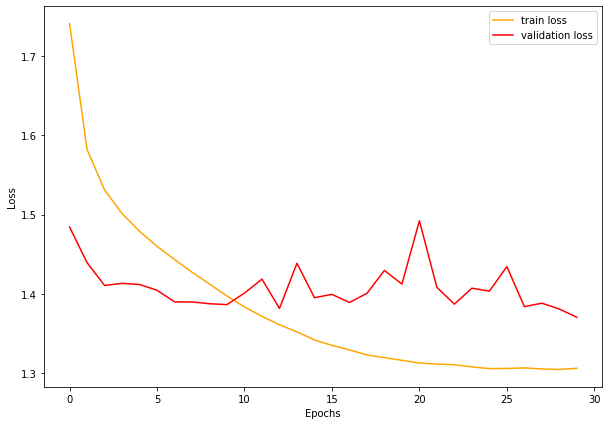

In [37]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss_1_aug, color='orange', label='train loss')
plt.plot(valid_loss_1_aug, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

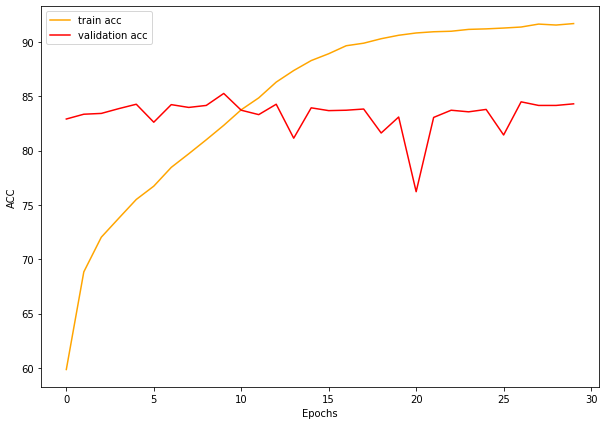

In [38]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_acc_1_aug, color='orange', label='train acc')
plt.plot(valid_acc_1_aug, color='red', label='validation acc')
plt.xlabel('Epochs')
plt.ylabel('ACC')
plt.legend()
plt.show()

### _Model 2_

In [39]:
# anomalies_to_include_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8]
# augments_to_include_2 = [0, 0, 0, 0]
# num_classes_2 = len(anomalies_to_include_2)

# model_2 = ResidualNet('ImageNet', 5, num_classes_2, 'CBAM')
# model_2.to(device) # sends model to GPU
# optimizer = optim.Adam(model_2.parameters(), lr=0.00003)

# train_dataset_2 = TeethDataLoader(train_path_to_df, anomalies_to_include_2, True, augments_to_include_2)
# valid_dataset_2 = TeethDataLoader(valid_path_to_df, anomalies_to_include_2, False, augments_to_include_2)

# # generate shuffled sequence of numbers based on how many images, split train/test
# train_idx_2 = np.array(range(len(train_dataset_2.labels)))
# shuffle(train_idx_2)
# valid_idx_2 = np.array(range(len(valid_dataset_2.labels)))
# shuffle(valid_idx_2)

# # Samples elements randomly from a given list of indices, without replacement
# train_sampler_2 = torch.utils.data.SubsetRandomSampler(train_idx_2)
# valid_sampler_2 = torch.utils.data.SubsetRandomSampler(valid_idx_2)

# # loads images associated with ids/samples from above
# train_loader_2 = torch.utils.data.DataLoader(train_dataset_2, batch_size=batch_size, sampler=train_sampler_2)
# valid_loader_2 = torch.utils.data.DataLoader(valid_dataset_2, batch_size=batch_size, sampler=valid_sampler_2)

In [40]:
# train_loss_2 = []
# valid_loss_2 = []
# train_acc_2 = []
# valid_acc_2 = []

# for epoch in range(1, epochs+1):
#     train_epoch_loss, train_epoch_accuracy = train(train_loader_2, model_2, num_classes_2, optimizer, epoch)
#     valid_epoch_loss, val_epoch_accuracy = valid(valid_loader_2, model_2, num_classes_2, epoch)
    
#     train_loss_2.append(train_epoch_loss)
#     valid_loss_2.append(valid_epoch_loss)
    
#     train_acc_2.append(train_epoch_accuracy)
#     valid_acc_2.append(val_epoch_accuracy)

In [41]:
# PATH = 'model_2.pth'
# torch.save(model_2.state_dict(), PATH)

In [42]:
# # plot and save the train and validation line graphs
# plt.figure(figsize=(10, 7))
# plt.plot(train_loss_2, color='orange', label='train loss')
# plt.plot(valid_loss_2, color='red', label='validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [43]:
# # plot and save the train and validation line graphs
# plt.figure(figsize=(10, 7))
# plt.plot(train_acc_2, color='orange', label='train acc')
# plt.plot(valid_acc_2, color='red', label='validation acc')
# plt.xlabel('Epochs')
# plt.ylabel('ACC')
# plt.legend()
# plt.show()

### _Model 2 with Augments_

In [44]:
# anomalies_to_include_2_aug = [0, 1, 2, 3, 4, 5, 6, 7, 8]
# augments_to_include_2_aug = [1, 1, 1, 1]

# num_classes_2_aug = len(anomalies_to_include_2_aug)

# model_2_aug = ResidualNet('ImageNet', 5, num_classes_2_aug, 'CBAM')
# model_2_aug.to(device) # sends model to GPU
# optimizer = optim.Adam(model_2_aug.parameters(), lr=0.00003)

# train_dataset_2_aug = TeethDataLoader(train_path_to_df, anomalies_to_include_2_aug, True, augments_to_include_2_aug)
# valid_dataset_2_aug = TeethDataLoader(valid_path_to_df, anomalies_to_include_2_aug, False, augments_to_include_2_aug)

# # generate shuffled sequence of numbers based on how many images, split train/test
# train_idx_2_aug = np.array(range(len(train_dataset_2_aug.labels)))
# shuffle(train_idx_2_aug)
# valid_idx_2_aug = np.array(range(len(valid_dataset_2_aug.labels)))
# shuffle(valid_idx_2_aug)

# # Samples elements randomly from a given list of indices, without replacement
# train_sampler_2_aug = torch.utils.data.SubsetRandomSampler(train_idx_2_aug)
# valid_sampler_2_aug = torch.utils.data.SubsetRandomSampler(valid_idx_2_aug)

# # loads images associated with ids/samples from above
# train_loader_2_aug = torch.utils.data.DataLoader(train_dataset_2_aug, batch_size=batch_size, sampler=train_sampler_2_aug)
# valid_loader_2_aug = torch.utils.data.DataLoader(valid_dataset_2_aug, batch_size=batch_size, sampler=valid_sampler_2_aug)

In [45]:
# train_loss_2_aug = []
# valid_loss_2_aug = []
# train_acc_2_aug = []
# valid_acc_2_aug = []

# for epoch in range(1, epochs+1):
#     train_epoch_loss, train_epoch_accuracy = train(train_loader_2_aug, model_2_aug, num_classes_2_aug, optimizer, epoch)
#     valid_epoch_loss, val_epoch_accuracy = valid(valid_loader_2_aug, model_2_aug, num_classes_2_aug, epoch)
    
#     train_loss_2_aug.append(train_epoch_loss)
#     valid_loss_2_aug.append(valid_epoch_loss)
    
#     train_acc_2_aug.append(train_epoch_accuracy)
#     valid_acc_2_aug.append(val_epoch_accuracy)

In [46]:
# PATH = 'model_2_aug.pth'
# torch.save(model_2_aug.state_dict(), PATH)

In [47]:
# # plot and save the train and validation line graphs
# plt.figure(figsize=(10, 7))
# plt.plot(train_loss_2_aug, color='orange', label='train loss')
# plt.plot(valid_loss_2_aug, color='red', label='validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [48]:
# # plot and save the train and validation line graphs
# plt.figure(figsize=(10, 7))
# plt.plot(train_acc_2_aug, color='orange', label='train acc')
# plt.plot(valid_acc_2_aug, color='red', label='validation acc')
# plt.xlabel('Epochs')
# plt.ylabel('ACC')
# plt.legend()
# plt.show()

# Look at Train and Validation Images

In [49]:
def display_images(df, anomaly_code, num_images=5):
    """
    Function displays validation using the file paths from a dataframe (so use the train_df or valid_df)
    Inputs:
        df: the df to get the file paths from
        anomaly_code: a list of the anomaly codes you want to display
        num_images: the number of images per anomaly code you want to show.  If 0, then display all.
    """
    for code in anomaly_code:        
        anomaly_filter = df['anomaly_codes'] == code
        temp_df = df[anomaly_filter]
        file_paths = sample(temp_df['file_path'].tolist(), num_images)
        
        for file in file_paths:
            img = plt.imread(file)
            plt.figure()
            plt.title(f'anomaly{code}')
            plt.imshow(img)  

In [50]:
display_anomalies = [0, 1, 2, 3, 4, 5, 6, 7, 8]

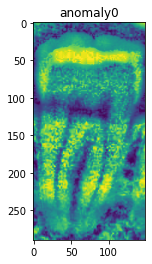

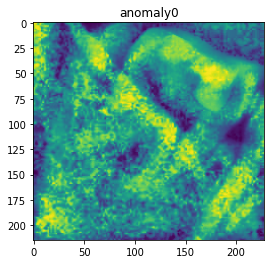

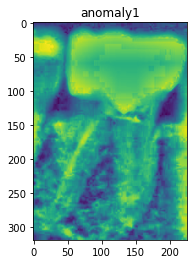

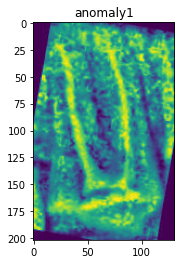

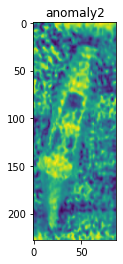

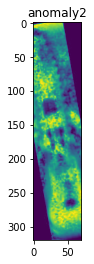

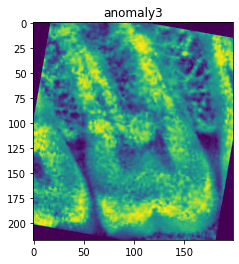

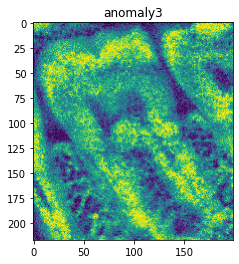

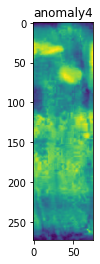

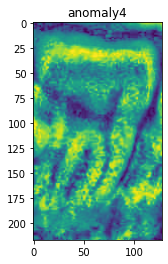

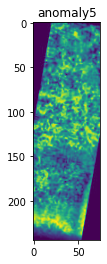

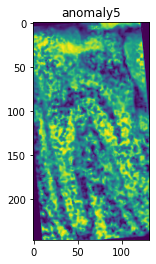

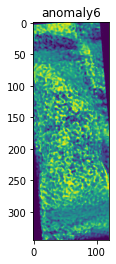

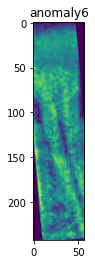

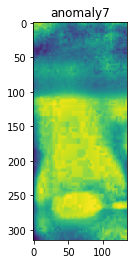

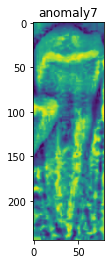

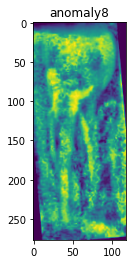

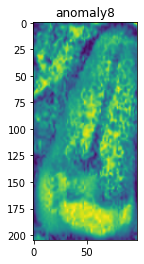

In [51]:
display_images(filter_rotation(train_aug_df, [[0,20], [160, 200], [340, 360]]), display_anomalies, num_images=2)

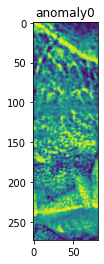

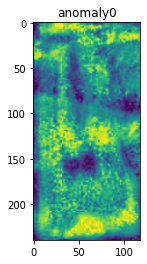

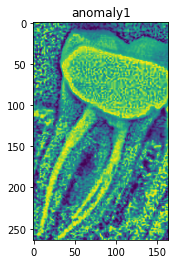

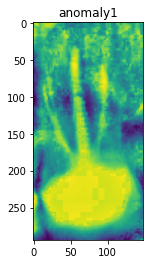

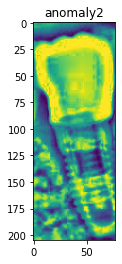

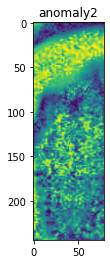

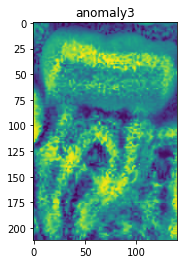

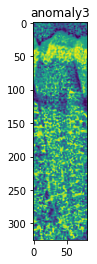

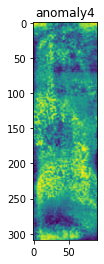

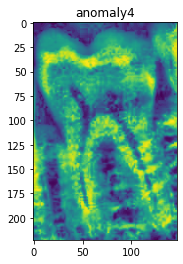

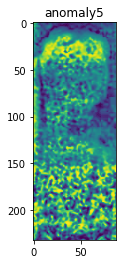

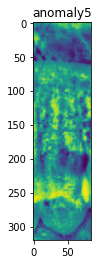

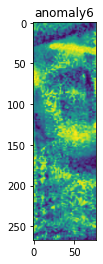

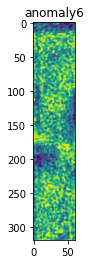

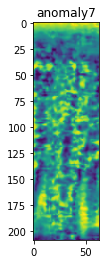

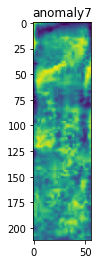

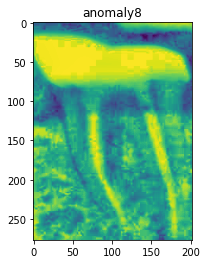

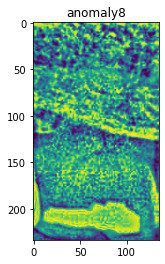

In [52]:
display_images(valid_df, display_anomalies, num_images=2)

# Look at Model Architecture

In [53]:
# os.environ["PATH"] += os.pathsep + 'C:\programdata\anaconda3\envs\dental_project_av\lib\site-packages\graphviz'
# os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38\bin'
# os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38\bin\dot.exe'

In [54]:
# !ls C:\programdata\anaconda3\envs\dental_project_av\lib\site-packages\graphviz

In [55]:
# print(os.environ["PATH"])

In [56]:
# batch = next(iter(train_loader_1))[0]
# batch = batch.to(device)

In [57]:
# yhat = model_1(batch)

In [58]:
# make_dot(yhat, params=dict(list(model_1.named_parameters()))).render("rnn_torchviz", format="png")

In [59]:
# x = torch.randn(64, 3, 224, 224)
# x = x.to(device)
# y = model_1(x)

In [60]:
# make_dot(y.mean(), params=dict(model_1.named_parameters()))

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model_1 = model_1.to(device)

In [62]:
summary(model_1, input_size=(3, 224, 224), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 112, 112]           9,408
       BatchNorm2d-2         [64, 64, 112, 112]             128
              ReLU-3         [64, 64, 112, 112]               0
         MaxPool2d-4           [64, 64, 56, 56]               0
            Conv2d-5           [64, 64, 56, 56]          36,864
       BatchNorm2d-6           [64, 64, 56, 56]             128
              ReLU-7           [64, 64, 56, 56]               0
            Conv2d-8           [64, 64, 56, 56]          36,864
       BatchNorm2d-9           [64, 64, 56, 56]             128
          Flatten-10                   [64, 64]               0
           Linear-11                    [64, 4]             260
             ReLU-12                    [64, 4]               0
           Linear-13                   [64, 64]             320
          Flatten-14                   

C:\ProgramData\Anaconda3\envs\dental_project_av\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
